In [ ]:
# !wget https://dataverse.harvard.edu/api/access/datafile/3107210?format=tab&gbrecs=true


--2021-12-24 11:40:04--  https://dataverse.harvard.edu/api/access/datafile/3107210?format=tab
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 35.175.164.183, 52.70.216.144, 107.20.115.215
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|35.175.164.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291997192 (278M) [text/tab-separated-values]
Saving to: ‘3107210?format=tab.1’

3107210?format=tab. 100%[===================>] 278.47M  83.8MB/s    in 3.3s    

2021-12-24 11:40:08 (83.8 MB/s) - ‘3107210?format=tab.1’ saved [291997192/291997192]



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div


from tqdm.notebook import tqdm, trange

In [2]:
df=pd.read_csv('world_polls.csv',sep='\t')
keys_cols=['polldate', 'election',	'system',	'rule',	'round','electionyr','elecdate']

In [3]:
def entropy(p,q):
  return - p*np.log(q)
  
def mse(y_true,y_pred):
  return np.square(y_pred-y_true)

def mae(y_true,y_pred):
  return np.abs(y_pred-y_true)

def error_p(p,n):
  return 1.96*np.sqrt(p*(1-p)/n)

def diff_error(p,q,n):
  err_th=error_p(p,n)
  err_obs=np.abs(p-q)
  return err_obs-err_th

def odd_err(p,v):
  return np.abs(np.log((p/(1-p))*(1-v)/v))

def extract(df,id_poll):
  sondage=df[df.idpoll==id_poll]
  return sondage.vote_,sondage.poll_, sondage.idpoll

In [4]:
def generate_id_poll(df_source,k_cols):
  df=df_source.copy()
  df['idpoll']=0
  keys=df[k_cols].drop_duplicates( ignore_index=True)
  print(f'Nombre de clefs {len(keys)}')
  for i in trange(len(keys)):
    filter=(df[keys_cols] ==keys[keys_cols].iloc[i]).sum(axis=1)==7
    df.loc[filter,'idpoll']=i
  return df

df=df[df.vote_.isna()==False]
df=df[df.poll_.isna()==False] 
df=generate_id_poll(df,keys_cols)

Nombre de clefs 23931


  0%|          | 0/23931 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df.to_pickle("polls.p")

In [5]:
df=pd.read_pickle("polls.p")
df=df[df["sample"]>0]

# df=df[df.yr>1995]
# df=df[df.daysbeforeED<14]

In [6]:
df

,polldate,election,system,rule,round,electionyr,elecdate,turnout,enpp,daysbeforeED,...,npolls,pollcycle,partyid,countryid,espv,regime,yr,electionid,country,idpoll
2084,1943-07-31,Legislative,Parliamentary,SMDP,1.0,1943.0,1943-08-21,96.320000,2.839419,21.0,...,1.0,21.0,1.0,2.0,Candidate,Old,1943.0,1943.1,Australia,0
2085,1943-07-31,Legislative,Parliamentary,SMDP,1.0,1943.0,1943-08-21,96.320000,2.839419,21.0,...,1.0,21.0,2.0,2.0,Candidate,Old,1943.0,1943.1,Australia,0
4352,1946-09-07,Legislative,Parliamentary,SMDP,1.0,1946.0,1946-09-28,93.970001,2.284524,21.0,...,1.0,21.0,1.0,2.0,Candidate,Old,1946.0,1946.1,Australia,1
4353,1946-09-07,Legislative,Parliamentary,SMDP,1.0,1946.0,1946-09-28,93.970001,2.284524,21.0,...,1.0,21.0,2.0,2.0,Candidate,Old,1946.0,1946.1,Australia,1
4380,1946-09-21,Legislative,Parliamentary,SMDP,1.0,1946.0,1946-09-28,93.970001,2.284524,7.0,...,1.0,21.0,1.0,2.0,Candidate,Old,1946.0,1946.1,Australia,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511758,2016-06-29,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,3.0,...,1.0,NaN,2.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23755
1511759,2016-06-29,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,3.0,...,1.0,NaN,4.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23755
1511760,2016-06-30,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,2.0,...,1.0,NaN,1.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23756
1511761,2016-06-30,Legislative,Parliamentary,SMDP,1.0,2016.0,2016-07-02,91.000000,NaN,2.0,...,1.0,NaN,2.0,2.0,Candidate,Old,2016.0,2016.1,Australia,23756


## Compute entropy


In [10]:
def poll_measure(df:pd.DataFrame,measure=entropy)->float:
  """
  df should store only one polls
  """
  y=df.vote_.to_numpy()/100
  yhat=df.poll_.to_numpy()/100
  if y.sum()<1:
    y=np.append(y,1-y.sum())
    yhat=np.append(yhat,1-yhat.sum())
    yhat[yhat<0]=0
  yhat[yhat==0]=0.00001
  return measure(y,yhat).sum()

poll_measure(df[df.idpoll==23756],measure=kl_div)

0.0007810374338687864

## Compute random sample

In [11]:
def random_sample_measure(df:pd.DataFrame,n_samples:int=1000,poll_size:int=None,measure=kl_div)->float:
  """
  df should store only one polls
  """
  y=df.vote_.to_numpy()/100
  if poll_size==None:
    poll_size=int(df['sample'].iloc[0])
  if y.sum()<1:
    y=np.append(y,1-y.sum())
  if y.sum()!=1.0:
    # Proba étrange ne sommant pas à 1
    y=y/y.sum()
  try:
    samples=np.random.choice(list(range(len(y))),size=(n_samples,poll_size),p=y)
  except :
    print(y,y.sum())
    return 0
  samples=np.eye(len(y))[samples]
  yhat=samples.sum(axis=1)
  yhat[yhat==0]=0.00001
  yhat=(yhat.T/yhat.sum(axis=1)).T
  measures=measure(y,yhat).sum(axis=1)
  return np.median(measures)

random_sample_measure(df[df.idpoll==23756],1000,1500,measure=kl_div)

0.000810727370421982

In [ ]:
a=np.random.normal(size=(2,4))
a=a-a.min()
a=a/a.sum(axis=1).reshape(-1,1)
b=np.random.normal(size=(4))
b=b-b.min()
b=b/b.sum(axis=1).reshape(-1,1)
print(a)
print(b)
print(kl_div(a,b))

AxisError: ignored

## Finding best random sampling through minimization

In [13]:
def optimal_size_sample(df:pd.DataFrame,n_samples:int=1000,measure=kl_div)->int:
  sample_size=int(df["sample"].iloc[0])
  lb=1
  ub=sample_size
  y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  y=poll_measure(df,measure=measure)
  while y-y_hat<-1e-5 and ub<16*sample_size:
    lb=ub
    ub=ub*2
    y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  if y-y_hat>0:
    while ub!=lb and ub!=lb+1:
      n=int((ub+lb)/2)
      y_hat=random_sample_measure(df,poll_size=n,n_samples=n_samples,measure=measure)
      r=y-y_hat
      if r>=0:
        ub=n
      else:
        lb=n
  return ub

optimal_size_sample(df[df.idpoll==23756],1000)

1568

In [14]:
from numpy.core.numeric import ones_like
samples_sizes=[]
for i in tqdm(df.idpoll.unique()):
  poll_df=df[df.idpoll==i]
  year=poll_df.yr.iloc[0]
  country=poll_df.country.iloc[0]
  election=poll_df.election.iloc[0]
  system=poll_df.system.iloc[0]
  daysbeforeED=poll_df.daysbeforeED.iloc[0]
  nb_candidates=len(poll_df)
  if poll_df.vote_.sum()<100:
    nb_candidates+=1
  n=int(poll_df["sample"].iloc[0])

  optimal_kl=optimal_size_sample(poll_df)
  optimal_entropy=optimal_size_sample(poll_df,measure=entropy)
  optimal_mse=optimal_size_sample(poll_df,measure=mse)
  optimal_mae=optimal_size_sample(poll_df,measure=mae)
  samples_sizes.append((i,n,optimal_kl,
                        optimal_entropy,optimal_mse,optimal_mae,
                        year,country,election,system,
                        daysbeforeED,nb_candidates))
best_sample_size=pd.DataFrame(samples_sizes,
                              columns=['id','poll_sample','optimal_kl',
                                       'optimal_entropy','optimal_mse','optimal_mae',
                                       'year','country','election',
                                       'system','daysbeforeED','nb_candidates'])


  0%|          | 0/23442 [00:00<?, ?it/s]

In [76]:
# best_sample_size.to_pickle("bss.p")
best_sample_size=pd.read_pickle("bss.p")
bss14=best_sample_size[best_sample_size.daysbeforeED<=14].copy()
liste_mesures=[['optimal_kl','optimal_entropy'],
               ['optimal_mse','optimal_mae'],
               ['oneshot','']]

nb_lignes=3
nb_colonnes=2

In [72]:
bss14

,id,poll_sample,optimal_kl,optimal_entropy,optimal_mse,optimal_mae,year,country,election,system,daysbeforeED,nb_candidates,bins,oneshot
2,2,2011,22,22,94,86,1946.0,Australia,Legislative,Parliamentary,7.0,3,"(-0.001, 24.0]",32176
4,4,1869,29,29,132,138,1949.0,Australia,Legislative,Parliamentary,7.0,3,"(-0.001, 24.0]",678
6,6,1630,54,57,86,81,1951.0,Australia,Legislative,Parliamentary,8.0,3,"(-0.001, 24.0]",1655
10,10,1983,38,37,77,72,1954.0,Australia,Legislative,Parliamentary,8.0,3,"(-0.001, 24.0]",8923
21,21,1760,64,65,150,137,1958.0,Australia,Legislative,Parliamentary,10.0,3,"(-0.001, 24.0]",730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23437,23752,3486,1440,1405,1096,1188,2016.0,Australia,Legislative,Parliamentary,8.0,4,"(-0.001, 24.0]",1941
23438,23753,1377,278,259,320,269,2016.0,Australia,Legislative,Parliamentary,5.0,4,"(-0.001, 24.0]",1033
23439,23754,2980,710,705,1102,1061,2016.0,Australia,Legislative,Parliamentary,4.0,4,"(-0.001, 24.0]",2468
23440,23755,4135,32203,33080,33080,42545,2016.0,Australia,Legislative,Parliamentary,3.0,4,"(-0.001, 24.0]",4135


## Précision en nombre de tirage aléatoire TCL

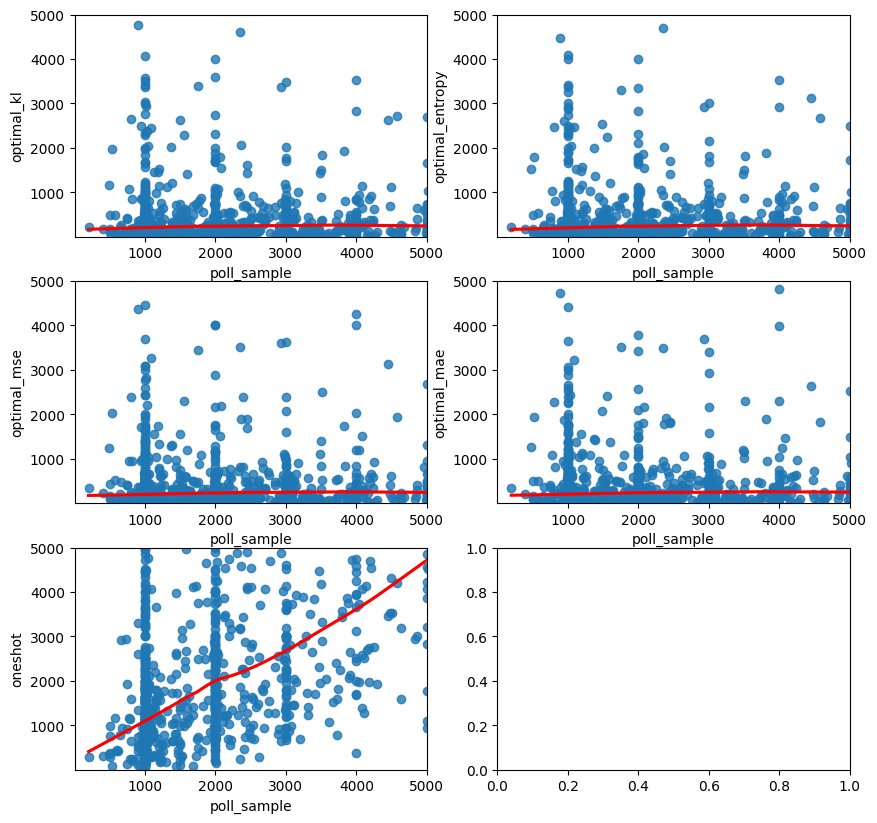

In [75]:
fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(10,10),dpi=100)
line=list(range(5000))
for i in range(nb_lignes):
    for j in range(nb_colonnes):
        if liste_mesures[i][j]!= '':
            ax=axes[i,j]
            g=sns.regplot(x='poll_sample',y=liste_mesures[i][j],
                        lowess=True,
                        data=bss14,
                        ax=ax,
                        line_kws={"color": "red"})
            ax.set_xlim(1, 5000)
            ax.set_ylim(1, 5000)

plt.show()

C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/3234731579.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_sample_size[best_sample_size['poll_sample']==1000].median()
C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/3234731579.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


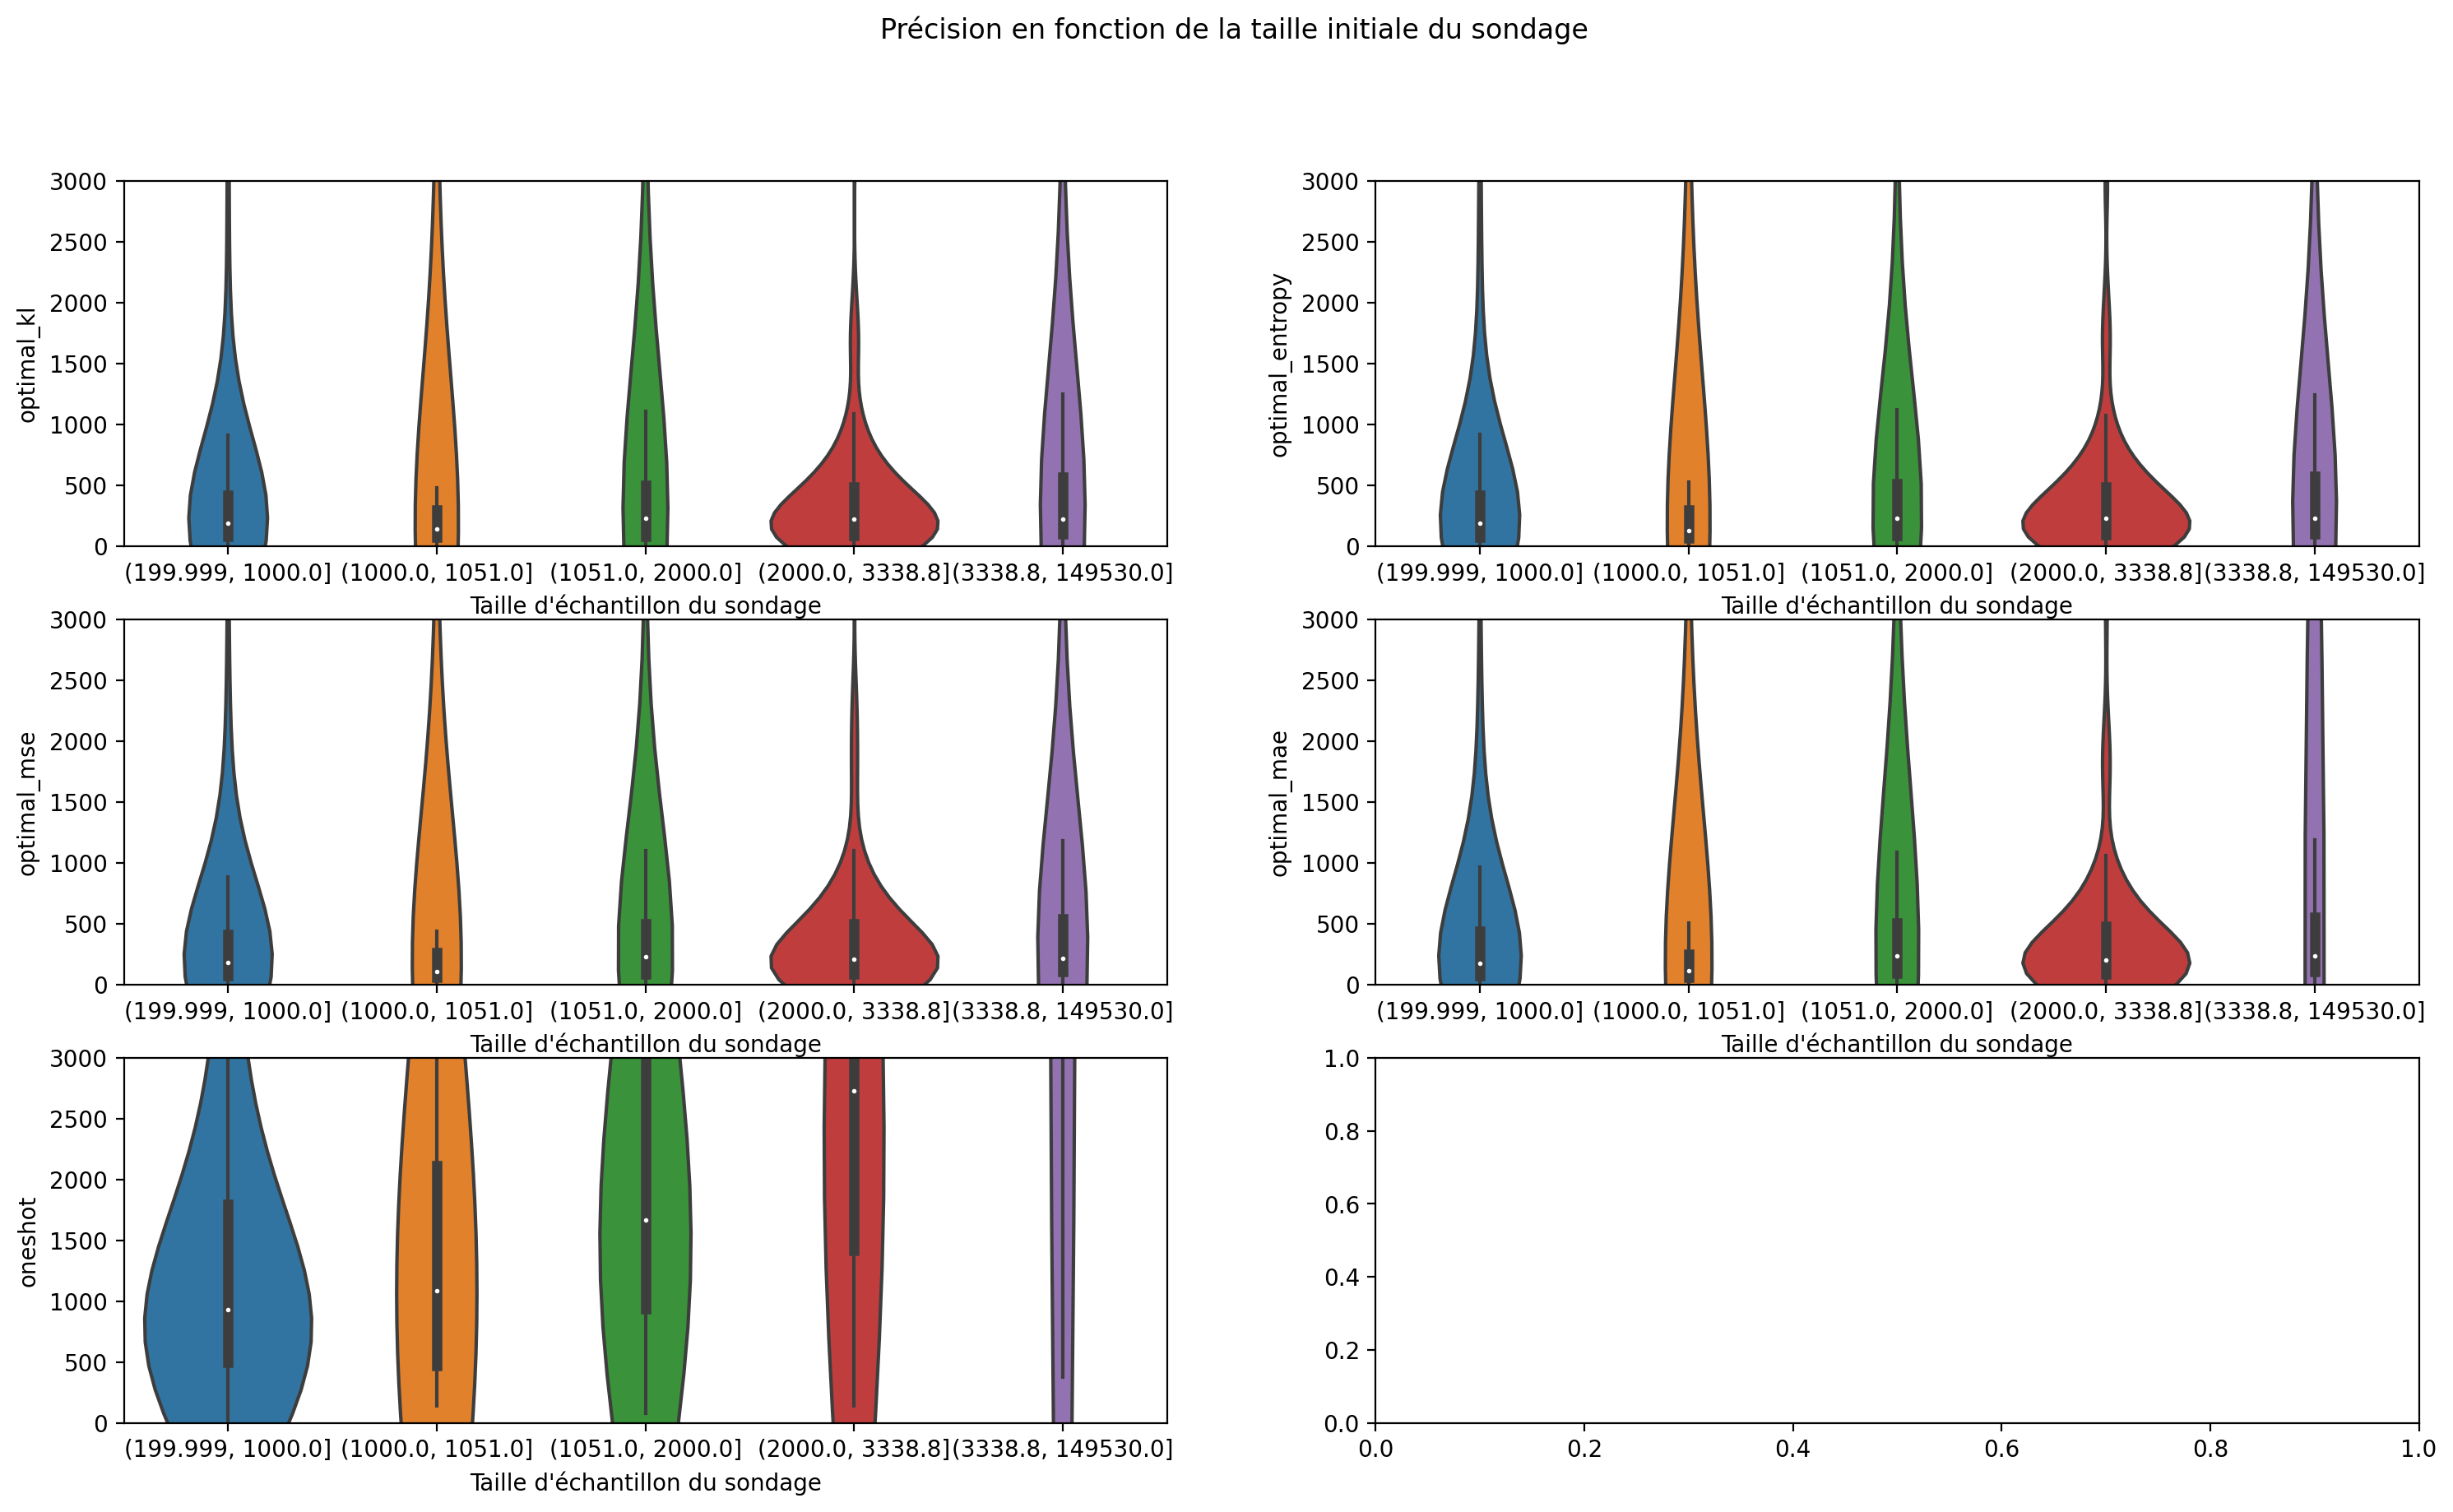

In [78]:
fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(18,10),dpi=200)
line=list(range(5000))
for i in range(nb_lignes):
    for j in range(nb_colonnes):
      if liste_mesures[i][j]!= '':
        ax=axes[i,j]
        bss14["bins"]=pd.qcut(bss14["poll_sample"], 5)
        sns.violinplot(x="bins",
                      y=liste_mesures[i][j],
                      data=bss14,
                      ax=ax,
                      #  inner="quartile"
                    )
        ax.set_xlabel("Taille d'échantillon du sondage")
        ax.set_ylim(0, 3000)
best_sample_size[best_sample_size['poll_sample']==1000].median()
fig.suptitle("Précision en fonction de la taille initiale du sondage")
fig.show()

C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/4055991212.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_sample_size[best_sample_size['poll_sample']==1000].median()
C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/4055991212.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


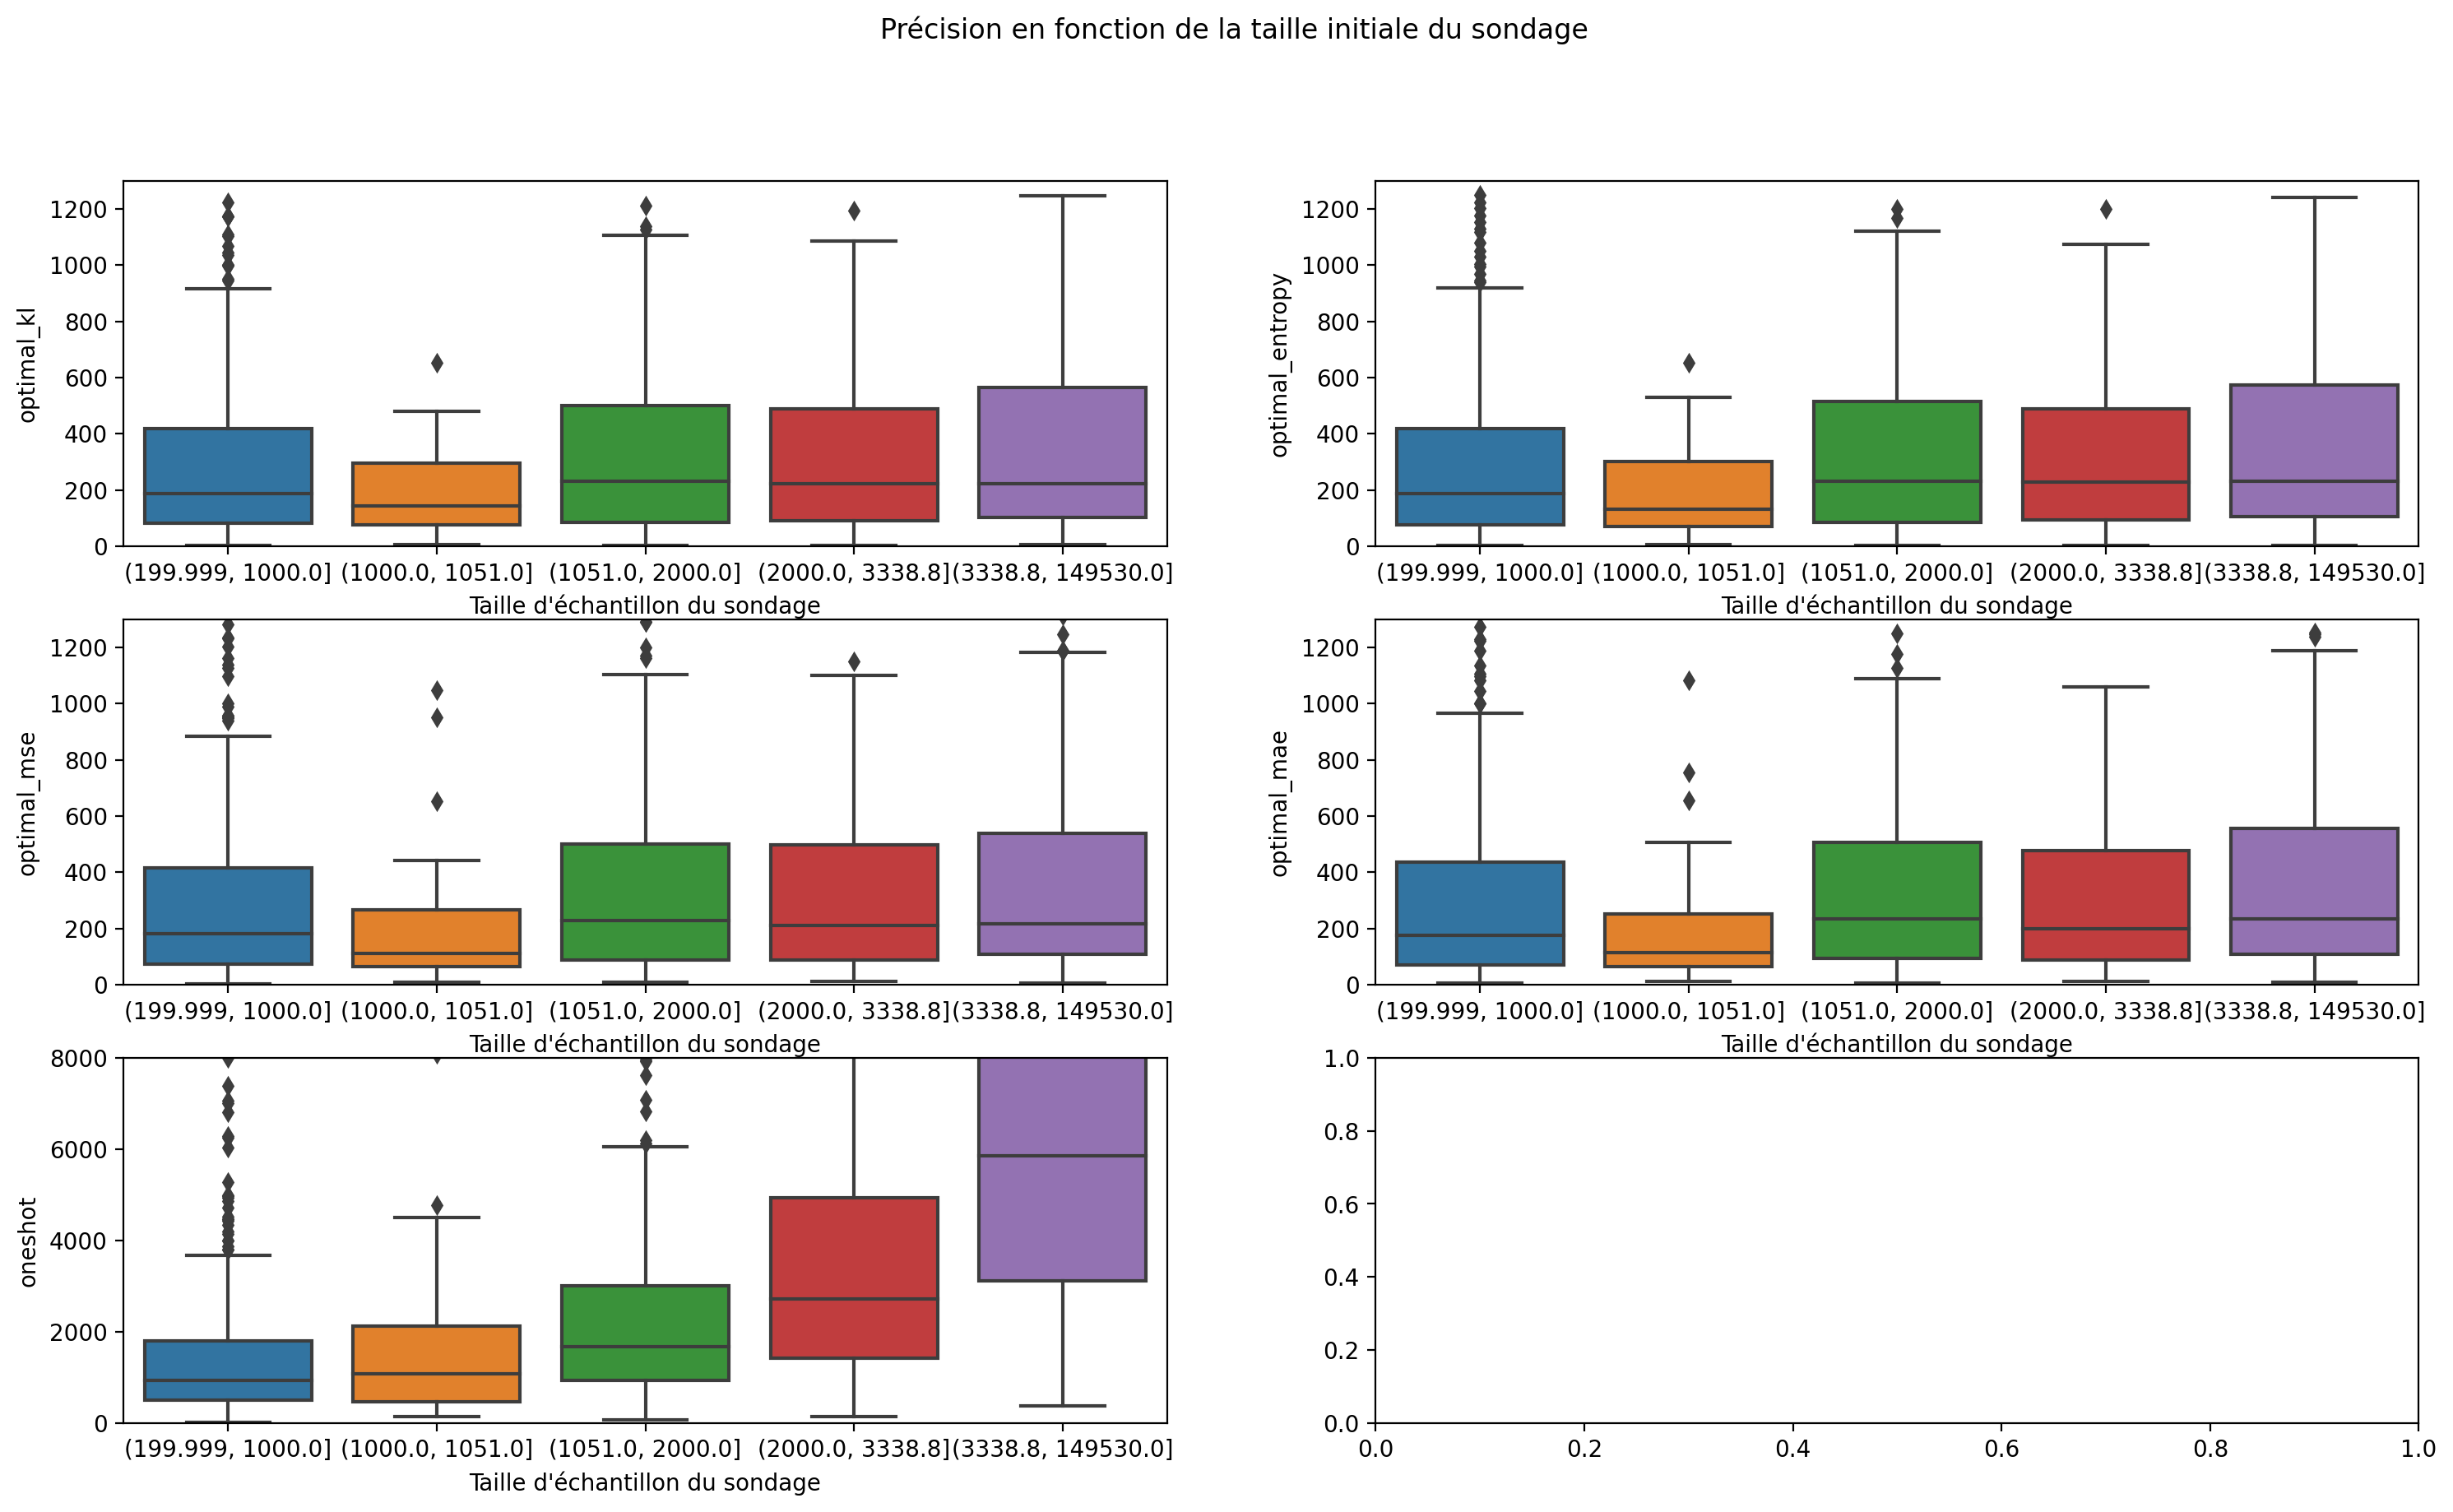

In [82]:
fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(18,10),dpi=200)
line=list(range(5000))
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i,j]
      bss14["bins"]=pd.qcut(bss14["poll_sample"], 5)
      sns.boxplot(x="bins",
                  y=liste_mesures[i][j],
                  data=bss14,
                  whis=1.5,          
                  ax=ax,    
                    #  inner="quartile"
                  )
      ax.set_ylim(0, 1300)
      if  liste_mesures[i][j]=='oneshot':
        ax.set_ylim(0, 8000)
      ax.set_xlabel("Taille d'échantillon du sondage")
best_sample_size[best_sample_size['poll_sample']==1000].median()
fig.suptitle("Précision en fonction de la taille initiale du sondage")
fig.show()

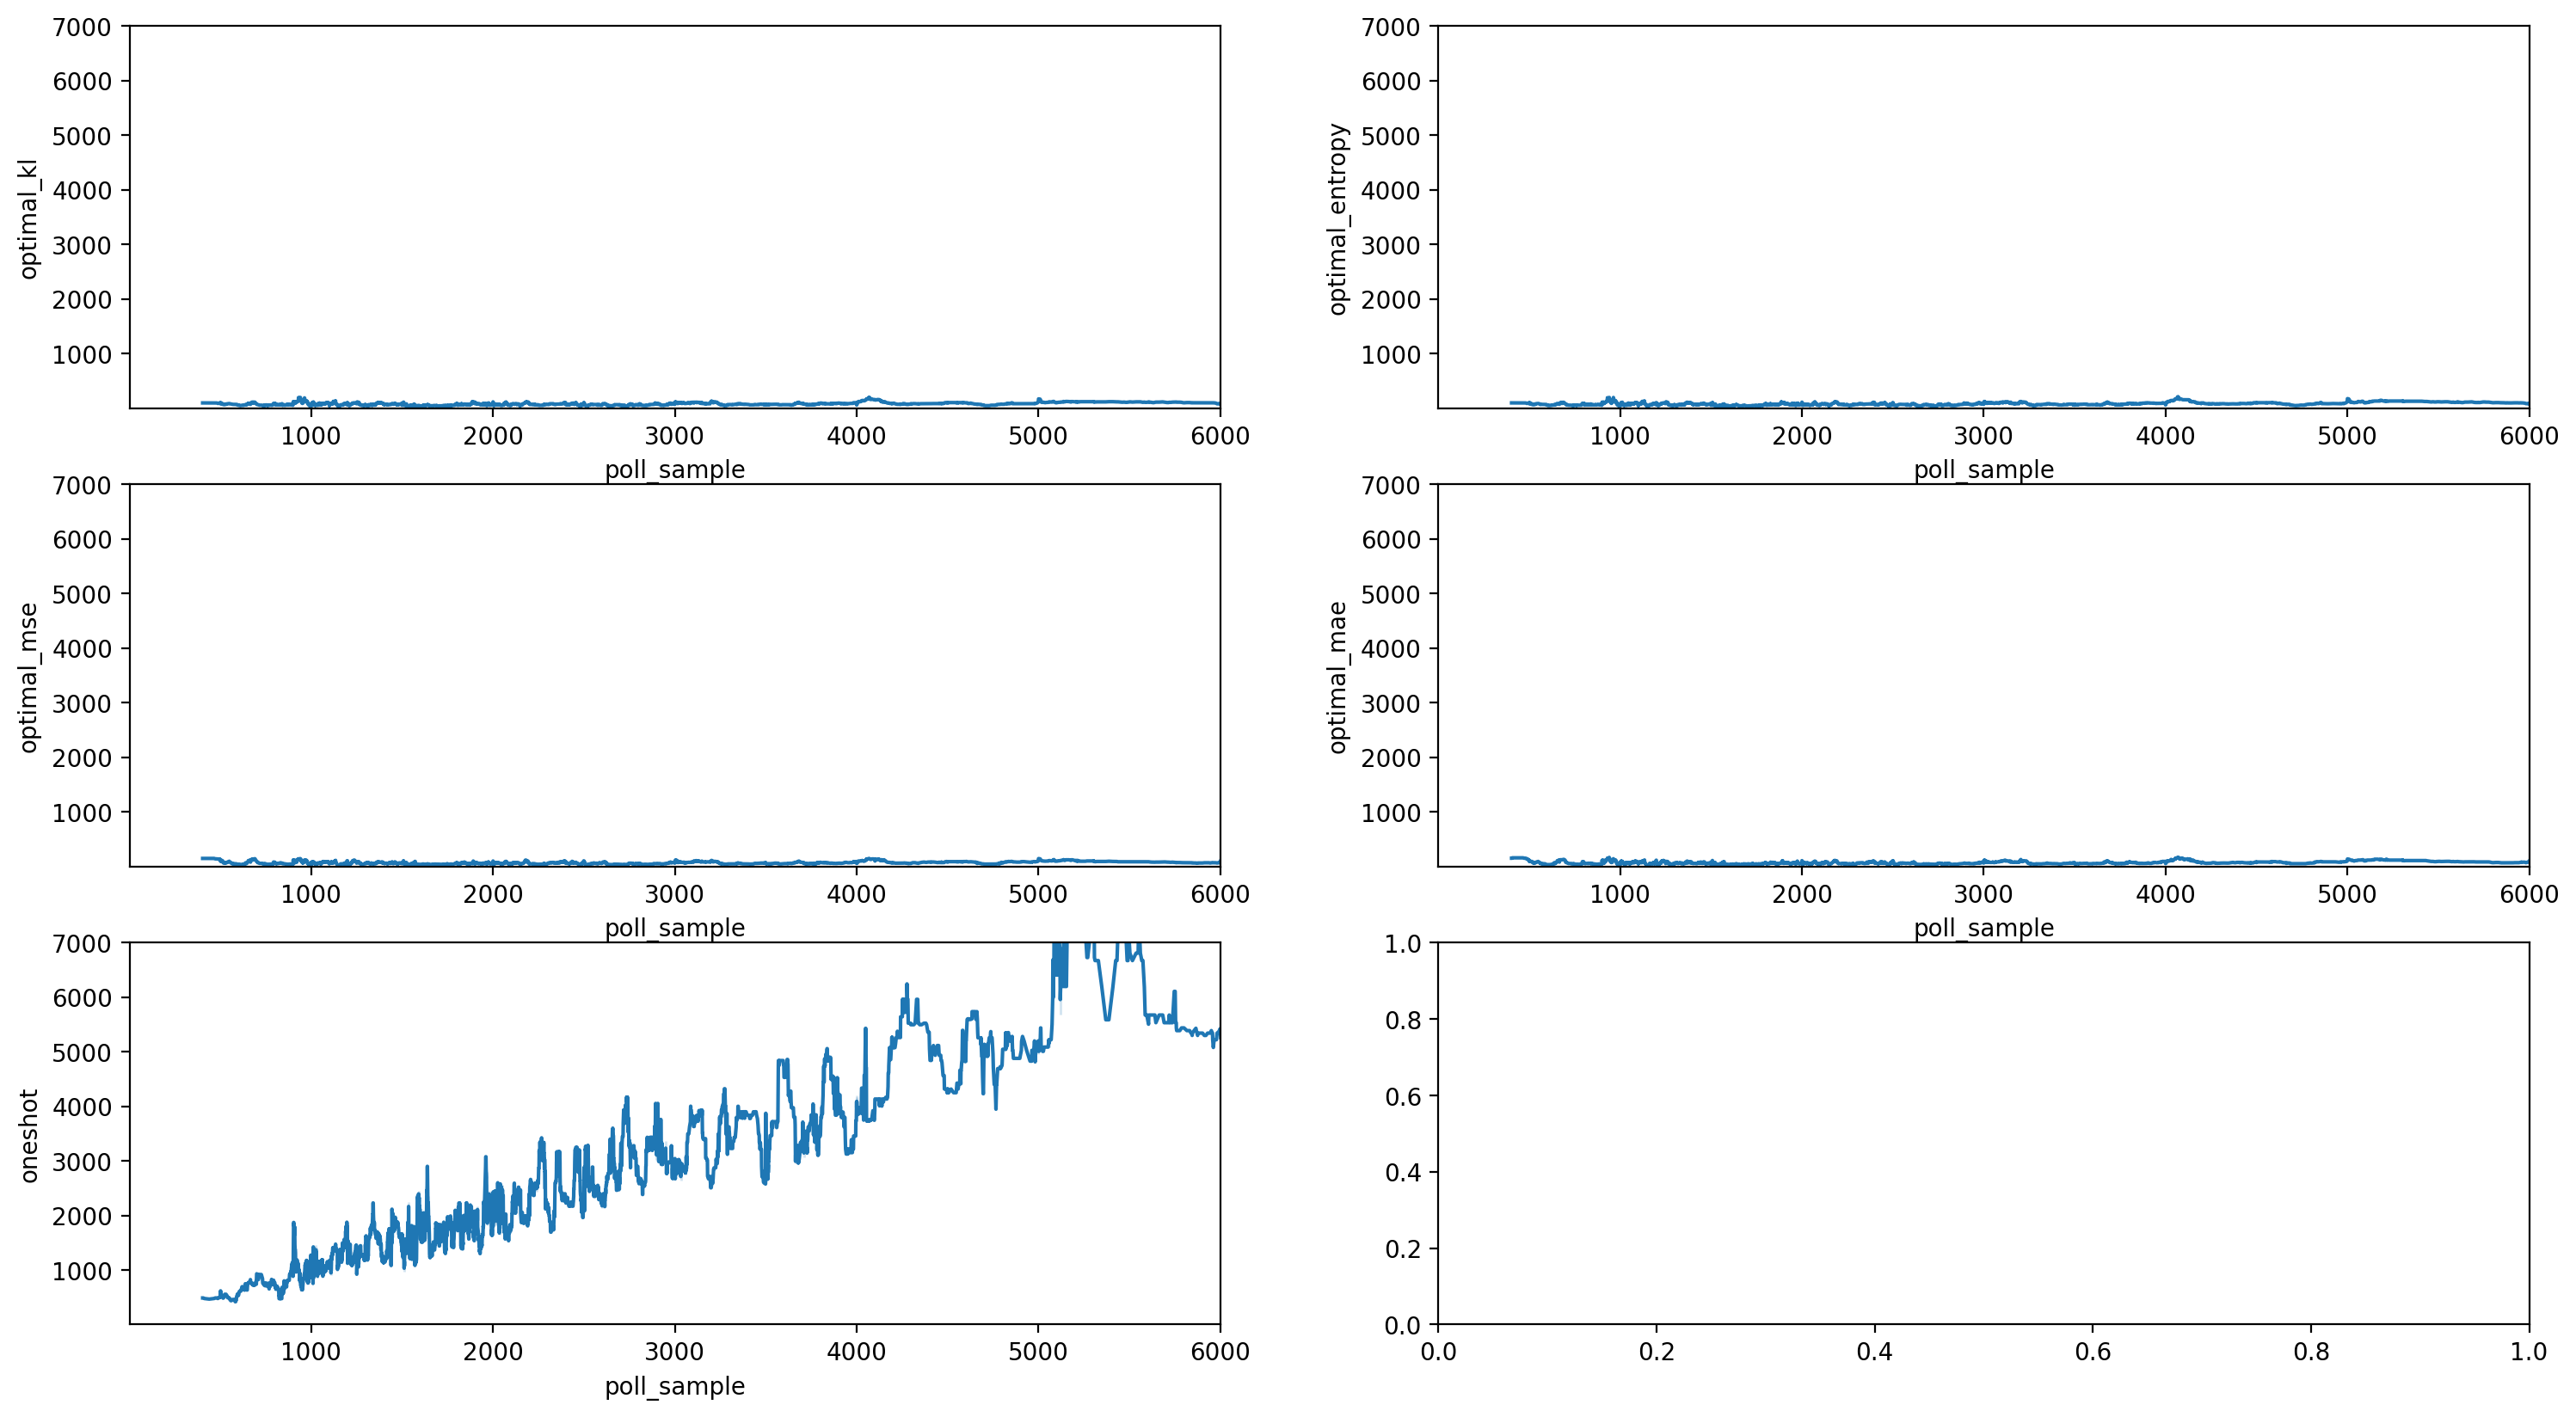

In [104]:
rolling_best=best_sample_size.sort_values('poll_sample').rolling(50).median()

fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(18,10),dpi=200)
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i,j]
      sns.lineplot(x='poll_sample',y=liste_mesures[i][j],data=rolling_best,ax=ax)
      ax.set_xlim(1, 6000)
      ax.set_ylim(1, 7000)
plt.show()

  0%|          | 0/3307 [00:00<?, ?it/s]

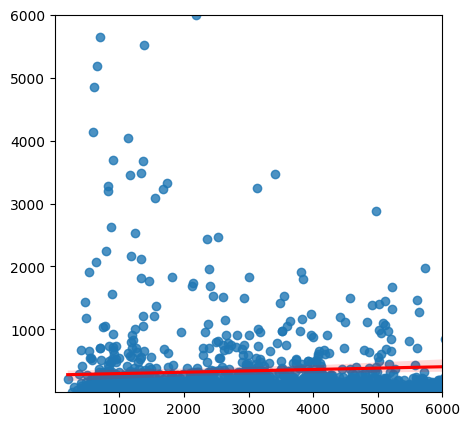

In [ ]:
x=[]
y=[]
for v in tqdm(best_sample_size['poll sample'].unique()):

  x.append(v)
  y.append(best_sample_size[best_sample_size['poll sample']==v]['random sample'].median())

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
sns.regplot(x=x,y=y,
            ax=ax,
            # lowess=True,
            line_kws={"color": "red"})
# plt.plot(line,line,'r')
ax.set_xlim(1, 6000)
ax.set_ylim(1, 6000)
plt.show()

## Précision au cours du temps


C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/250539735.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


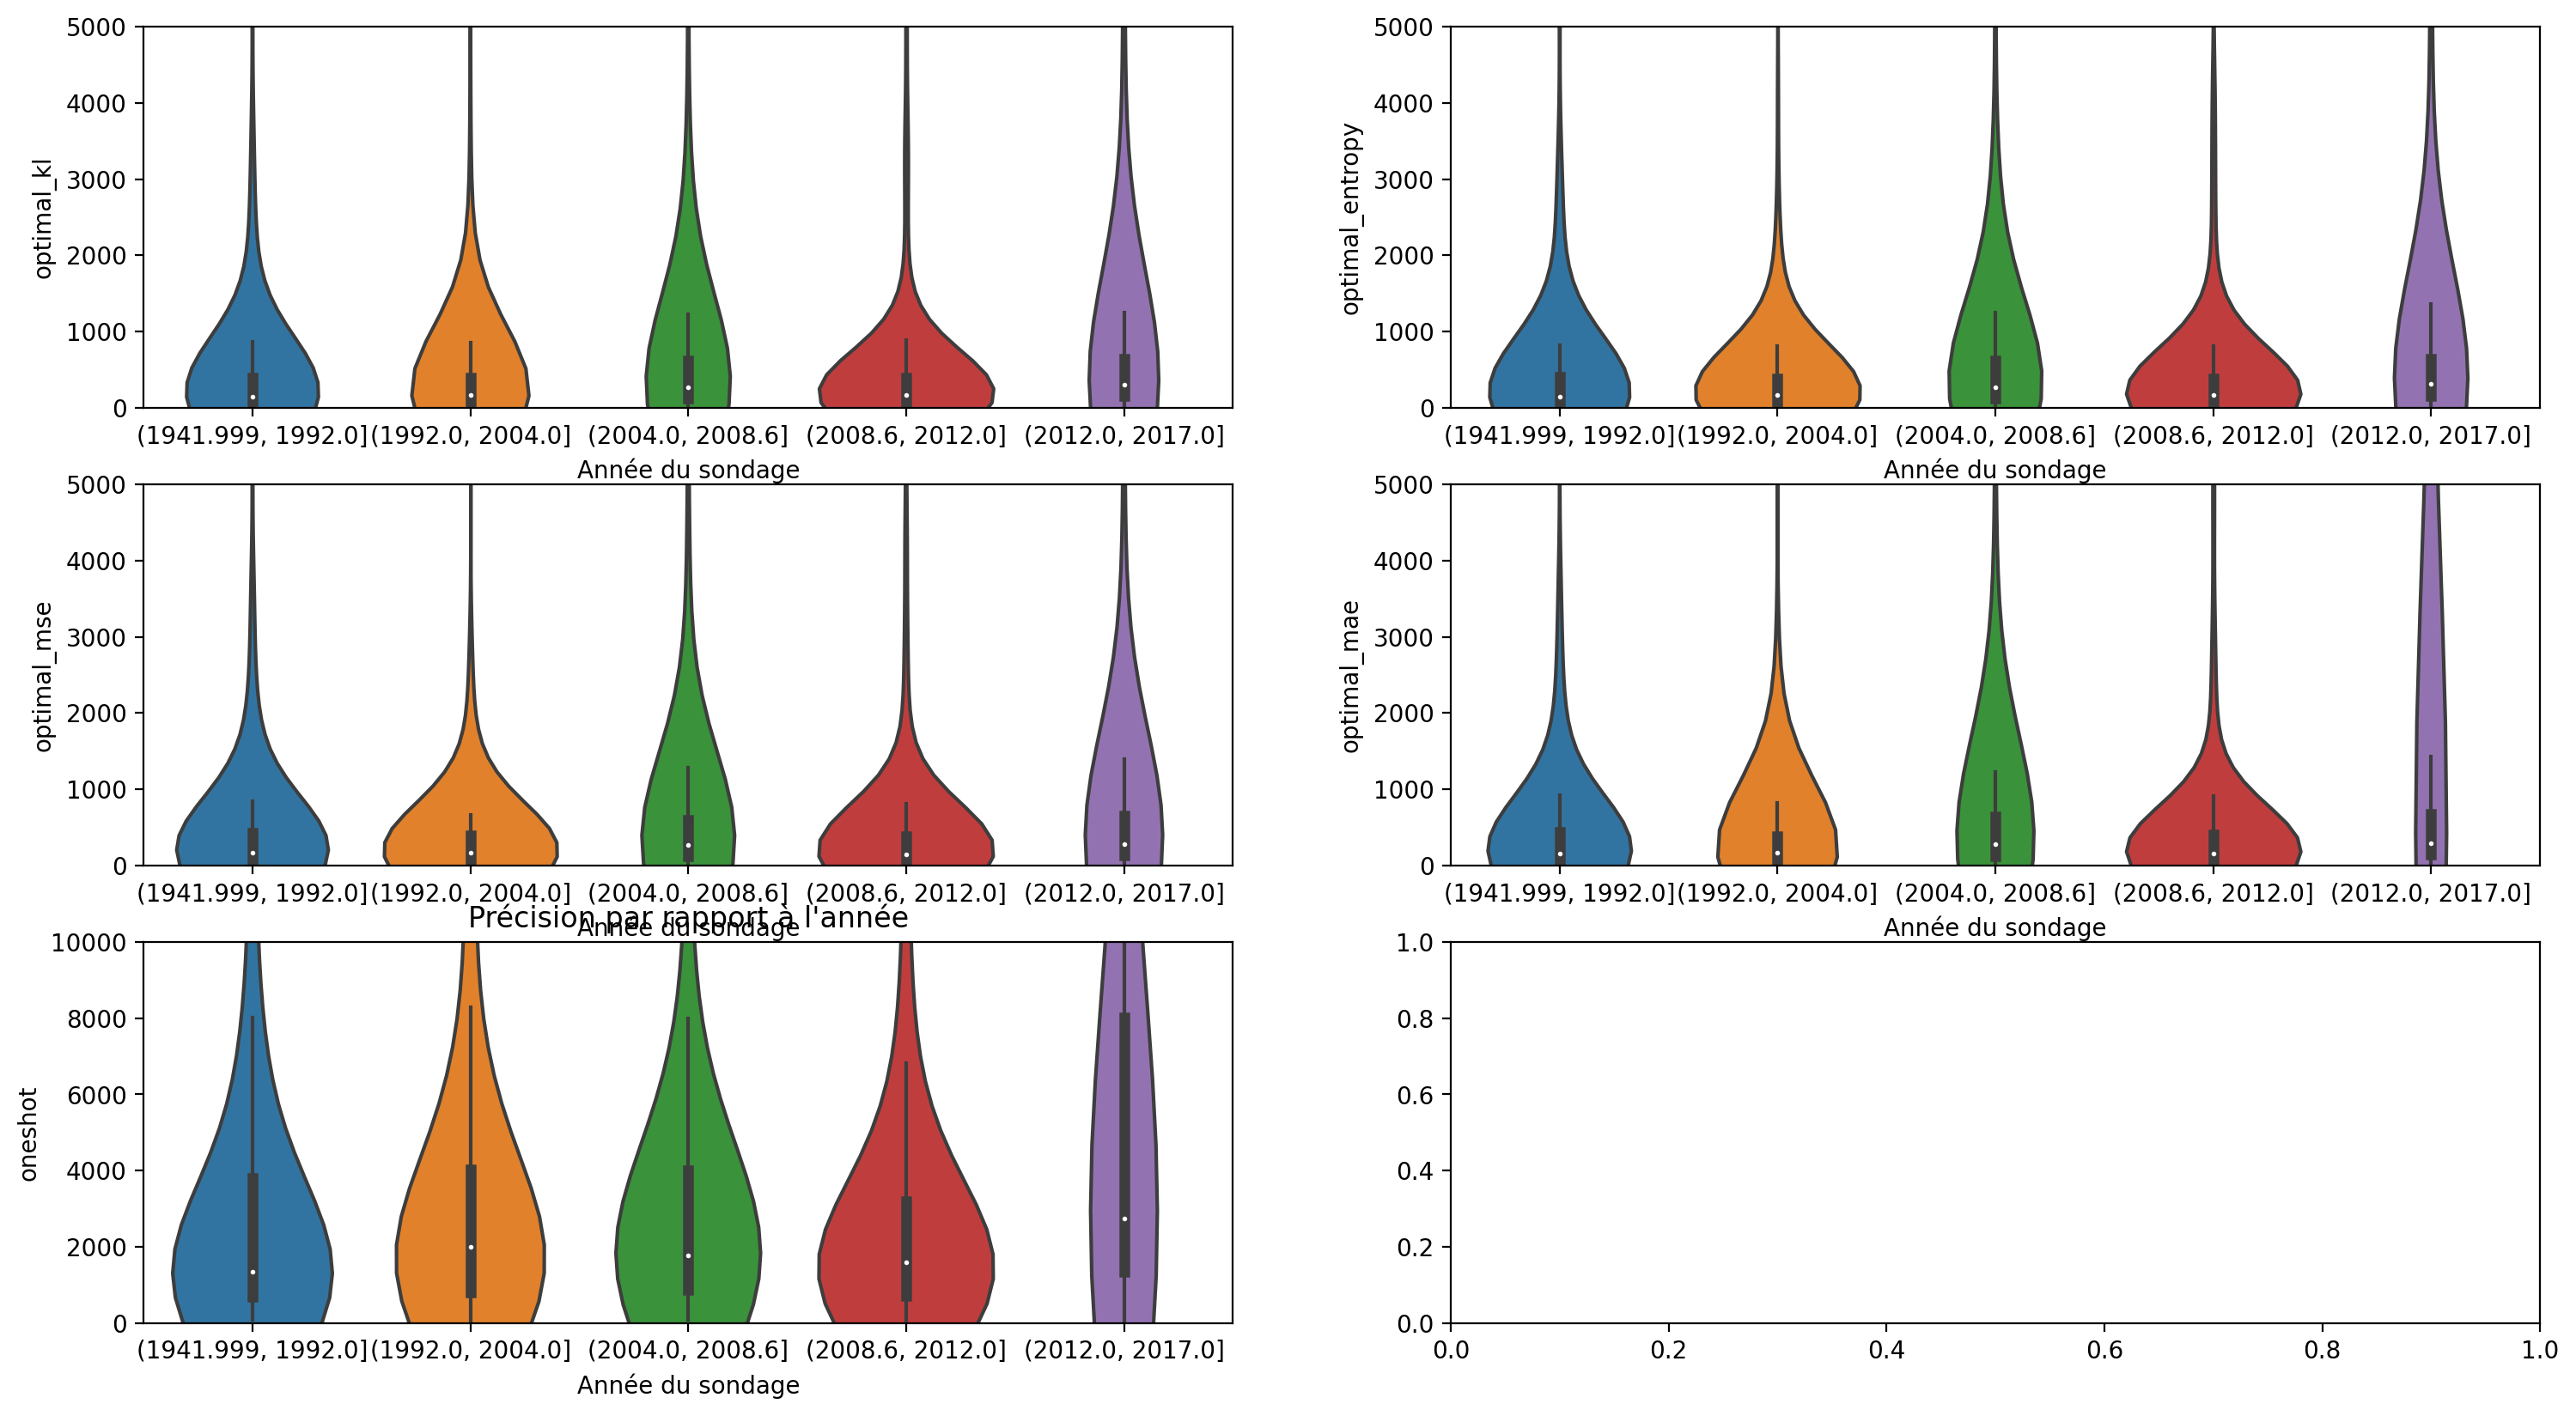

In [102]:
# fig, ax = plt.subplots(figsize=(5,5),dpi=100)
# # g=sns.regplot(x='year',y='random sample',
# #               lowess=True,
# #               data=bss14,
# #               ax=ax,
# #               line_kws={"color": "red"})
# ax.set_ylim(1, 5000)
# plt.show()
fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(18,10),dpi=200)
line=list(range(5000))
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i,j]
      bss14["bins"]=pd.qcut(bss14["year"], 5)
      sns.violinplot(x="bins",
                    y=liste_mesures[i][j],
                    data=bss14,
                    ax=ax,
                    #  inner="quartile"
                  )
      ax.set_ylim(0, 5000)
      if liste_mesures[i][j]== 'oneshot':
        ax.set_ylim(0, 10000)
      ax.set_xlabel("Année du sondage")
ax.set_title("Précision par rapport à l'année")
fig.show()

C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/308473882.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


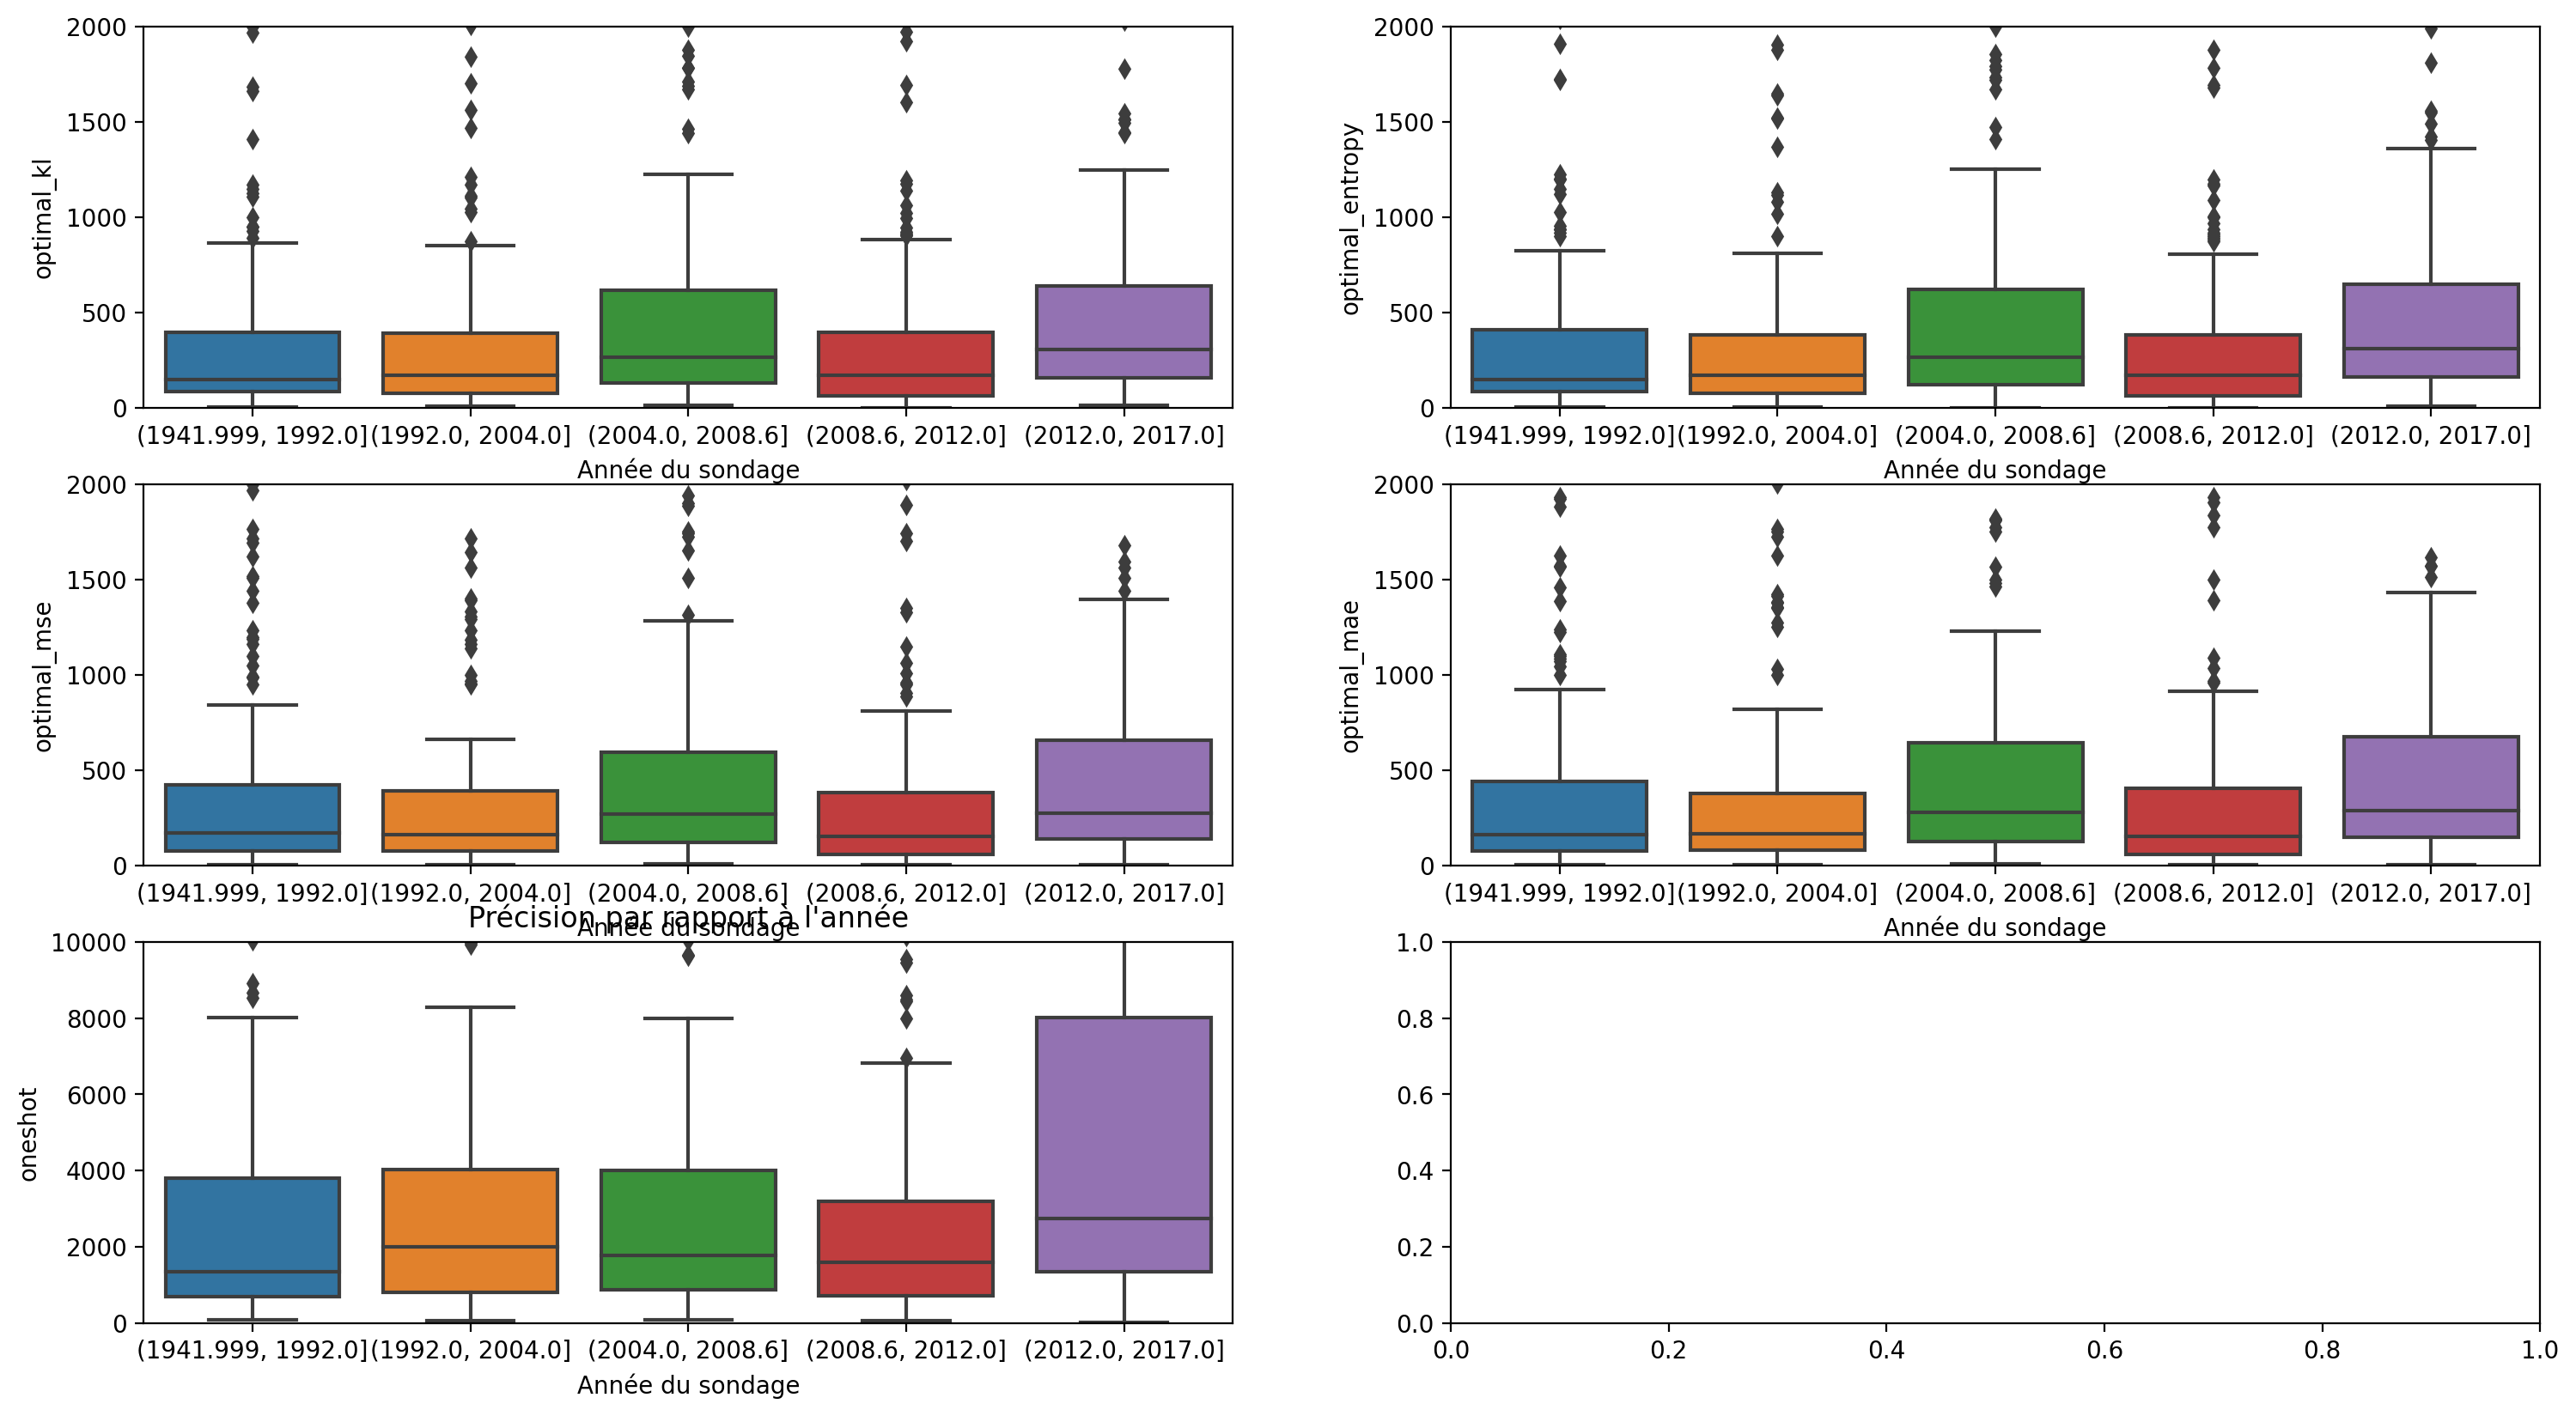

In [101]:
fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(18,10),dpi=200)
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i,j]
      bss14["bins"]=pd.qcut(bss14["year"], 5)
      sns.boxplot(x="bins",
                    y=liste_mesures[i][j],
                    data=bss14,
                    ax=ax,
                    #  inner="quartile"
                  )
      ax.set_ylim(0,2000)
      if liste_mesures[i][j]== 'oneshot':
        ax.set_ylim(0, 10000)
      ax.set_xlabel("Année du sondage")
ax.set_title("Précision par rapport à l'année")
fig.show()

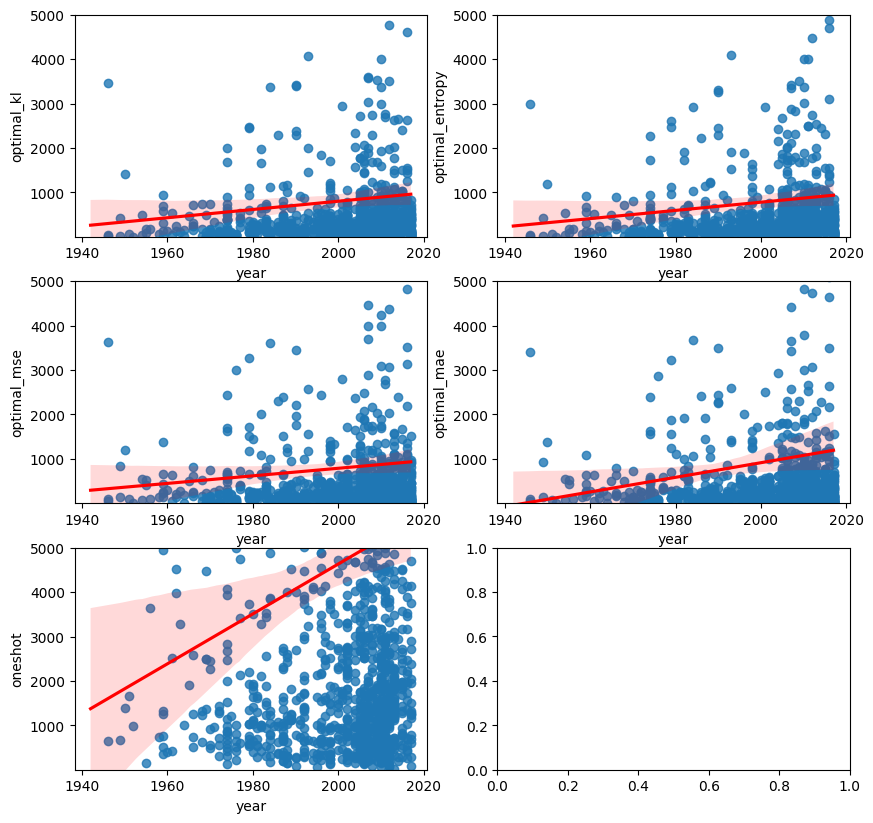

In [86]:
fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(10,10),dpi=100)
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i,j]
      g=sns.regplot(x='year',y=liste_mesures[i][j],
                  data=best_sample_size[best_sample_size['daysbeforeED']<14],
                  ax=ax,
                  line_kws={"color": "red"})
      ax.set_ylim(1, 5000)
plt.show()

## Précision en fonction de l'écart à la date d'élection

C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/221322984.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


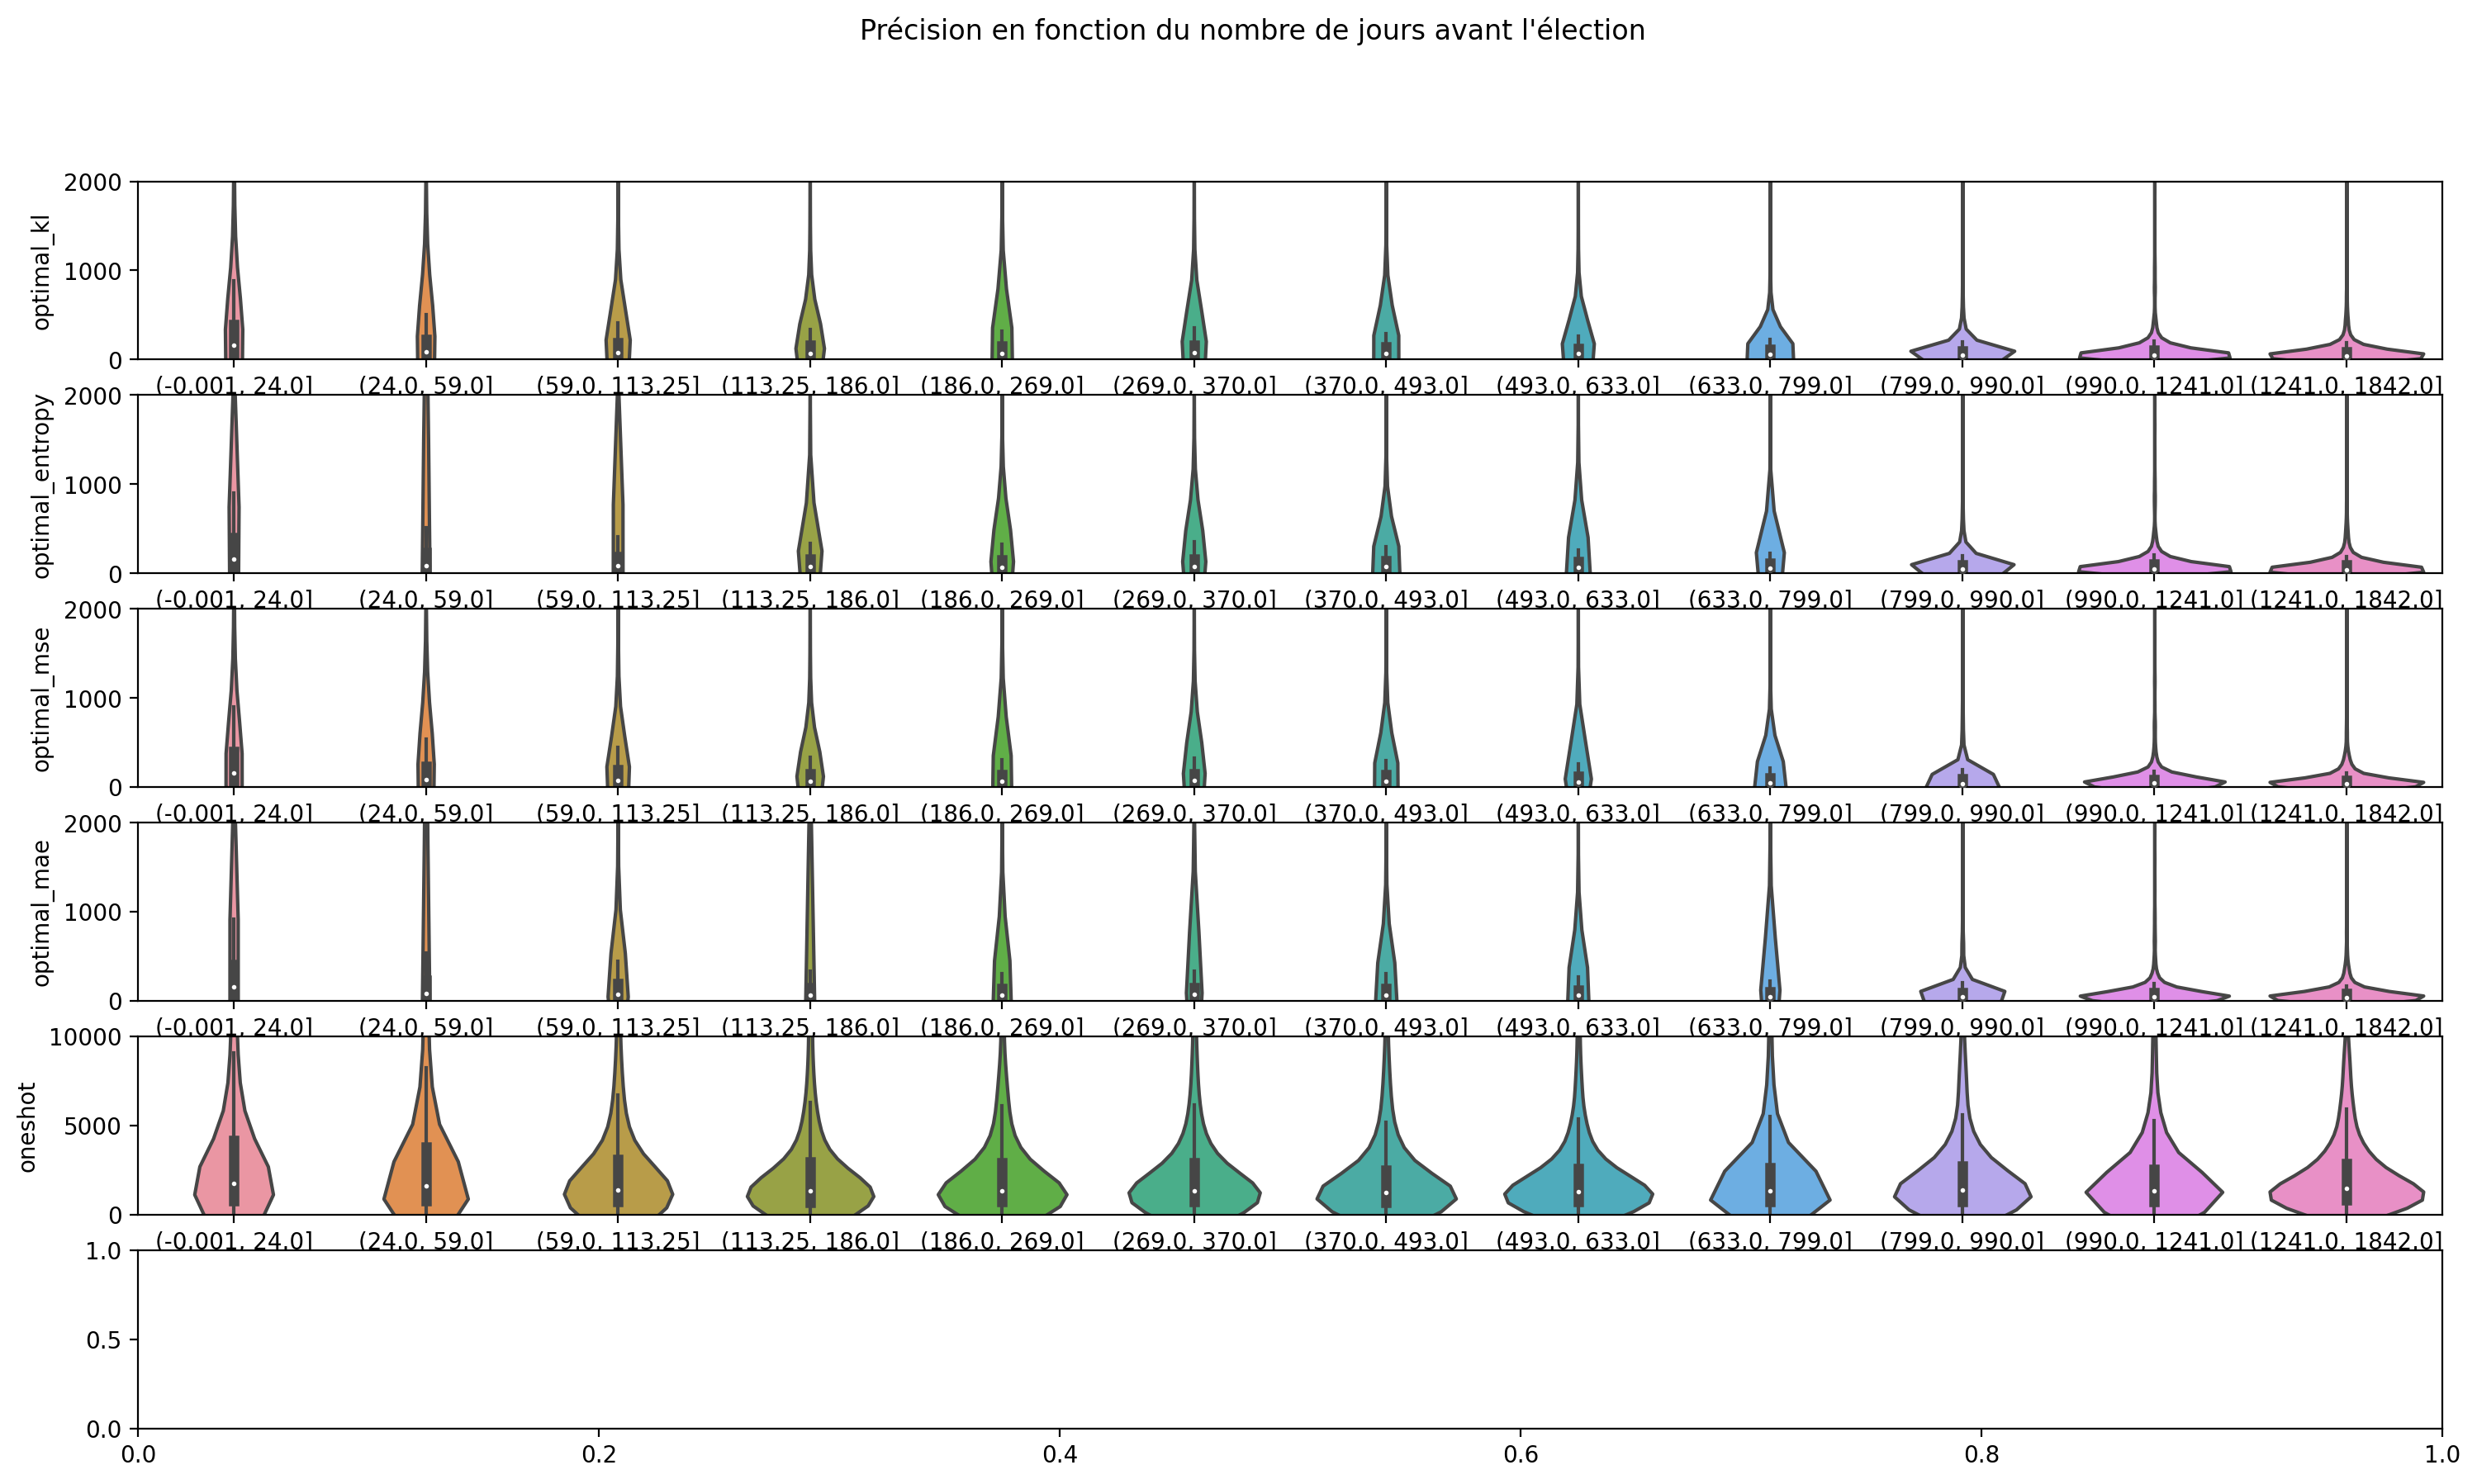

In [100]:

fig, axes = plt.subplots(nb_lignes*nb_colonnes,1,figsize=(18,10),dpi=200)
line=list(range(5000))
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i*2+j]
      best_sample_size["bins"]=pd.qcut(best_sample_size["daysbeforeED"], 12)
      sns.violinplot(x="bins",
                    y=liste_mesures[i][j],
                    data=best_sample_size,
                    ax=ax,
                    #  inner="quartile"
                  )
      ax.set_ylim(0, 2000)
      if liste_mesures[i][j]== 'oneshot':
        ax.set_ylim(0, 10000)
      ax.set_xlabel("Nb jours avant élection")
fig.suptitle("Précision en fonction du nombre de jours avant l'élection")
fig.show()

C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/1730048007.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


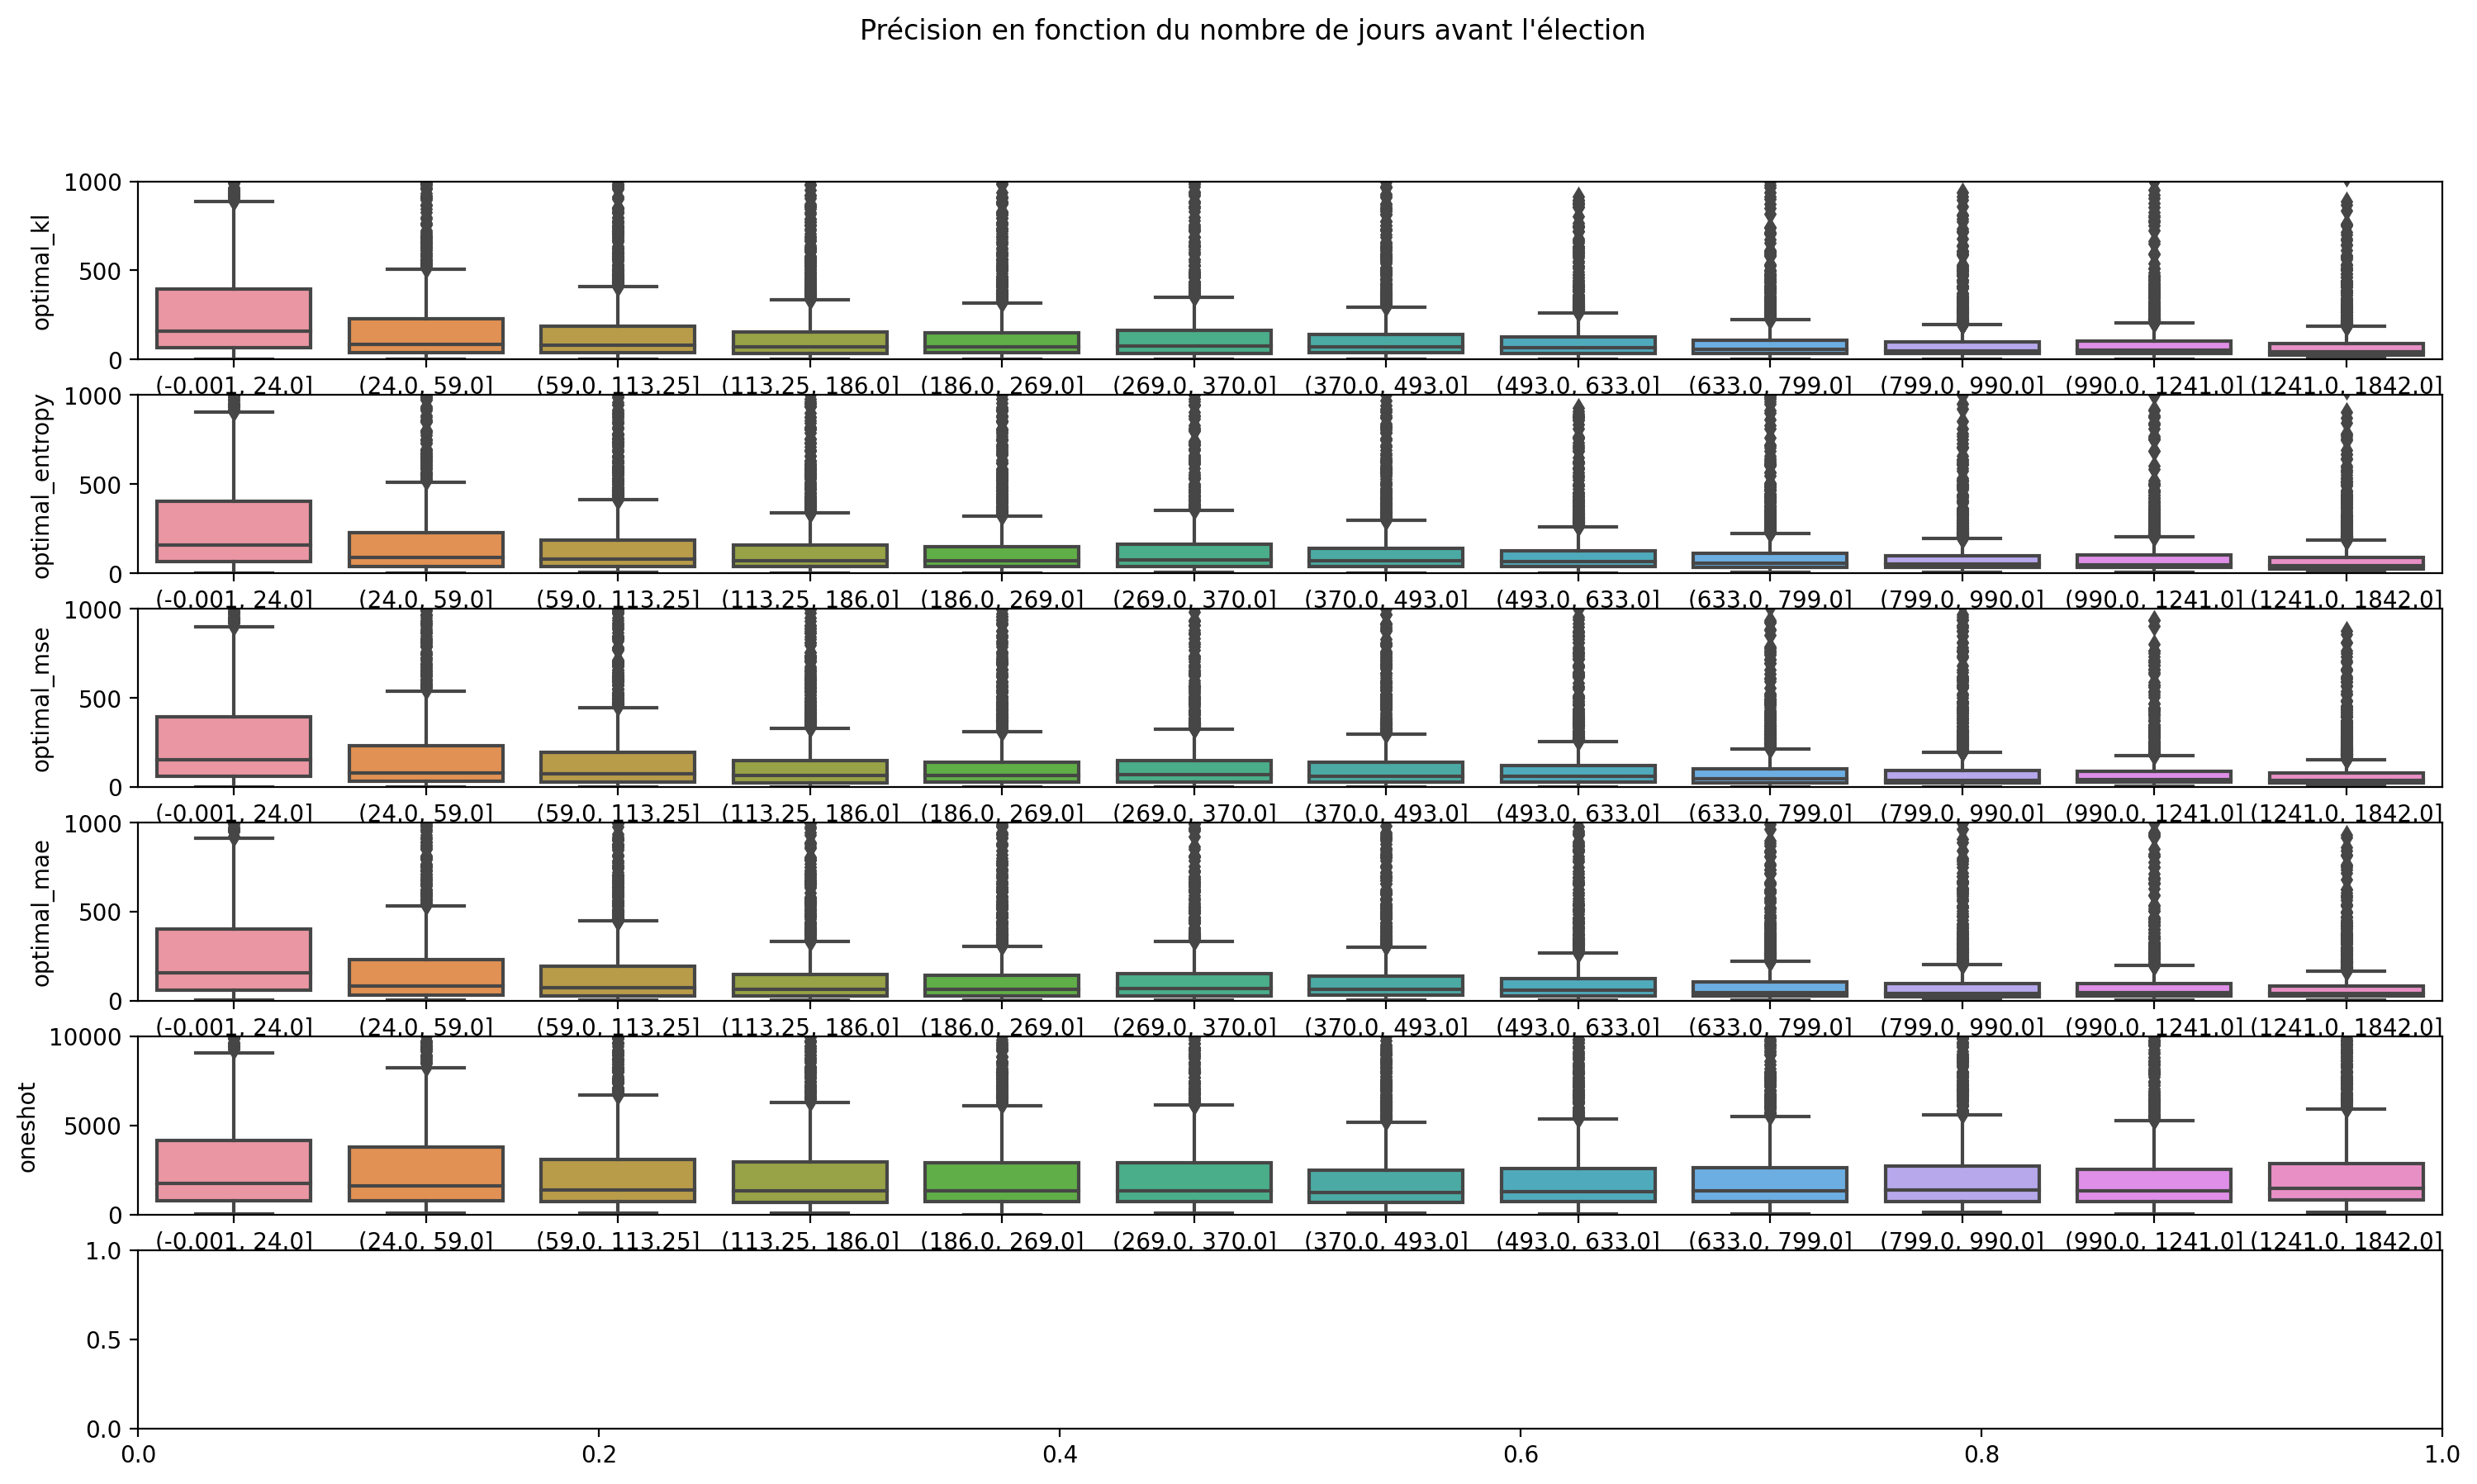

In [99]:
fig, axes = plt.subplots(nb_lignes*nb_colonnes,1,figsize=(18,10),dpi=200)
line=list(range(5000))
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i*2+j]
      best_sample_size["bins"]=pd.qcut(best_sample_size["daysbeforeED"], 12)
      sns.boxplot(x="bins",
                    y=liste_mesures[i][j],
                    data=best_sample_size,
                    ax=ax,
                    #  inner="quartile"
                  )
      ax.set_ylim(0, 1000)
      if liste_mesures[i][j]== 'oneshot':
        ax.set_ylim(0, 10000)
      ax.set_xlabel("Nb jours avant élection")
fig.suptitle("Précision en fonction du nombre de jours avant l'élection")
fig.show()

## Précision en fonction du nombre de partis présentés


C:\Users\Romain\AppData\Local\Temp/ipykernel_16372/3623418937.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


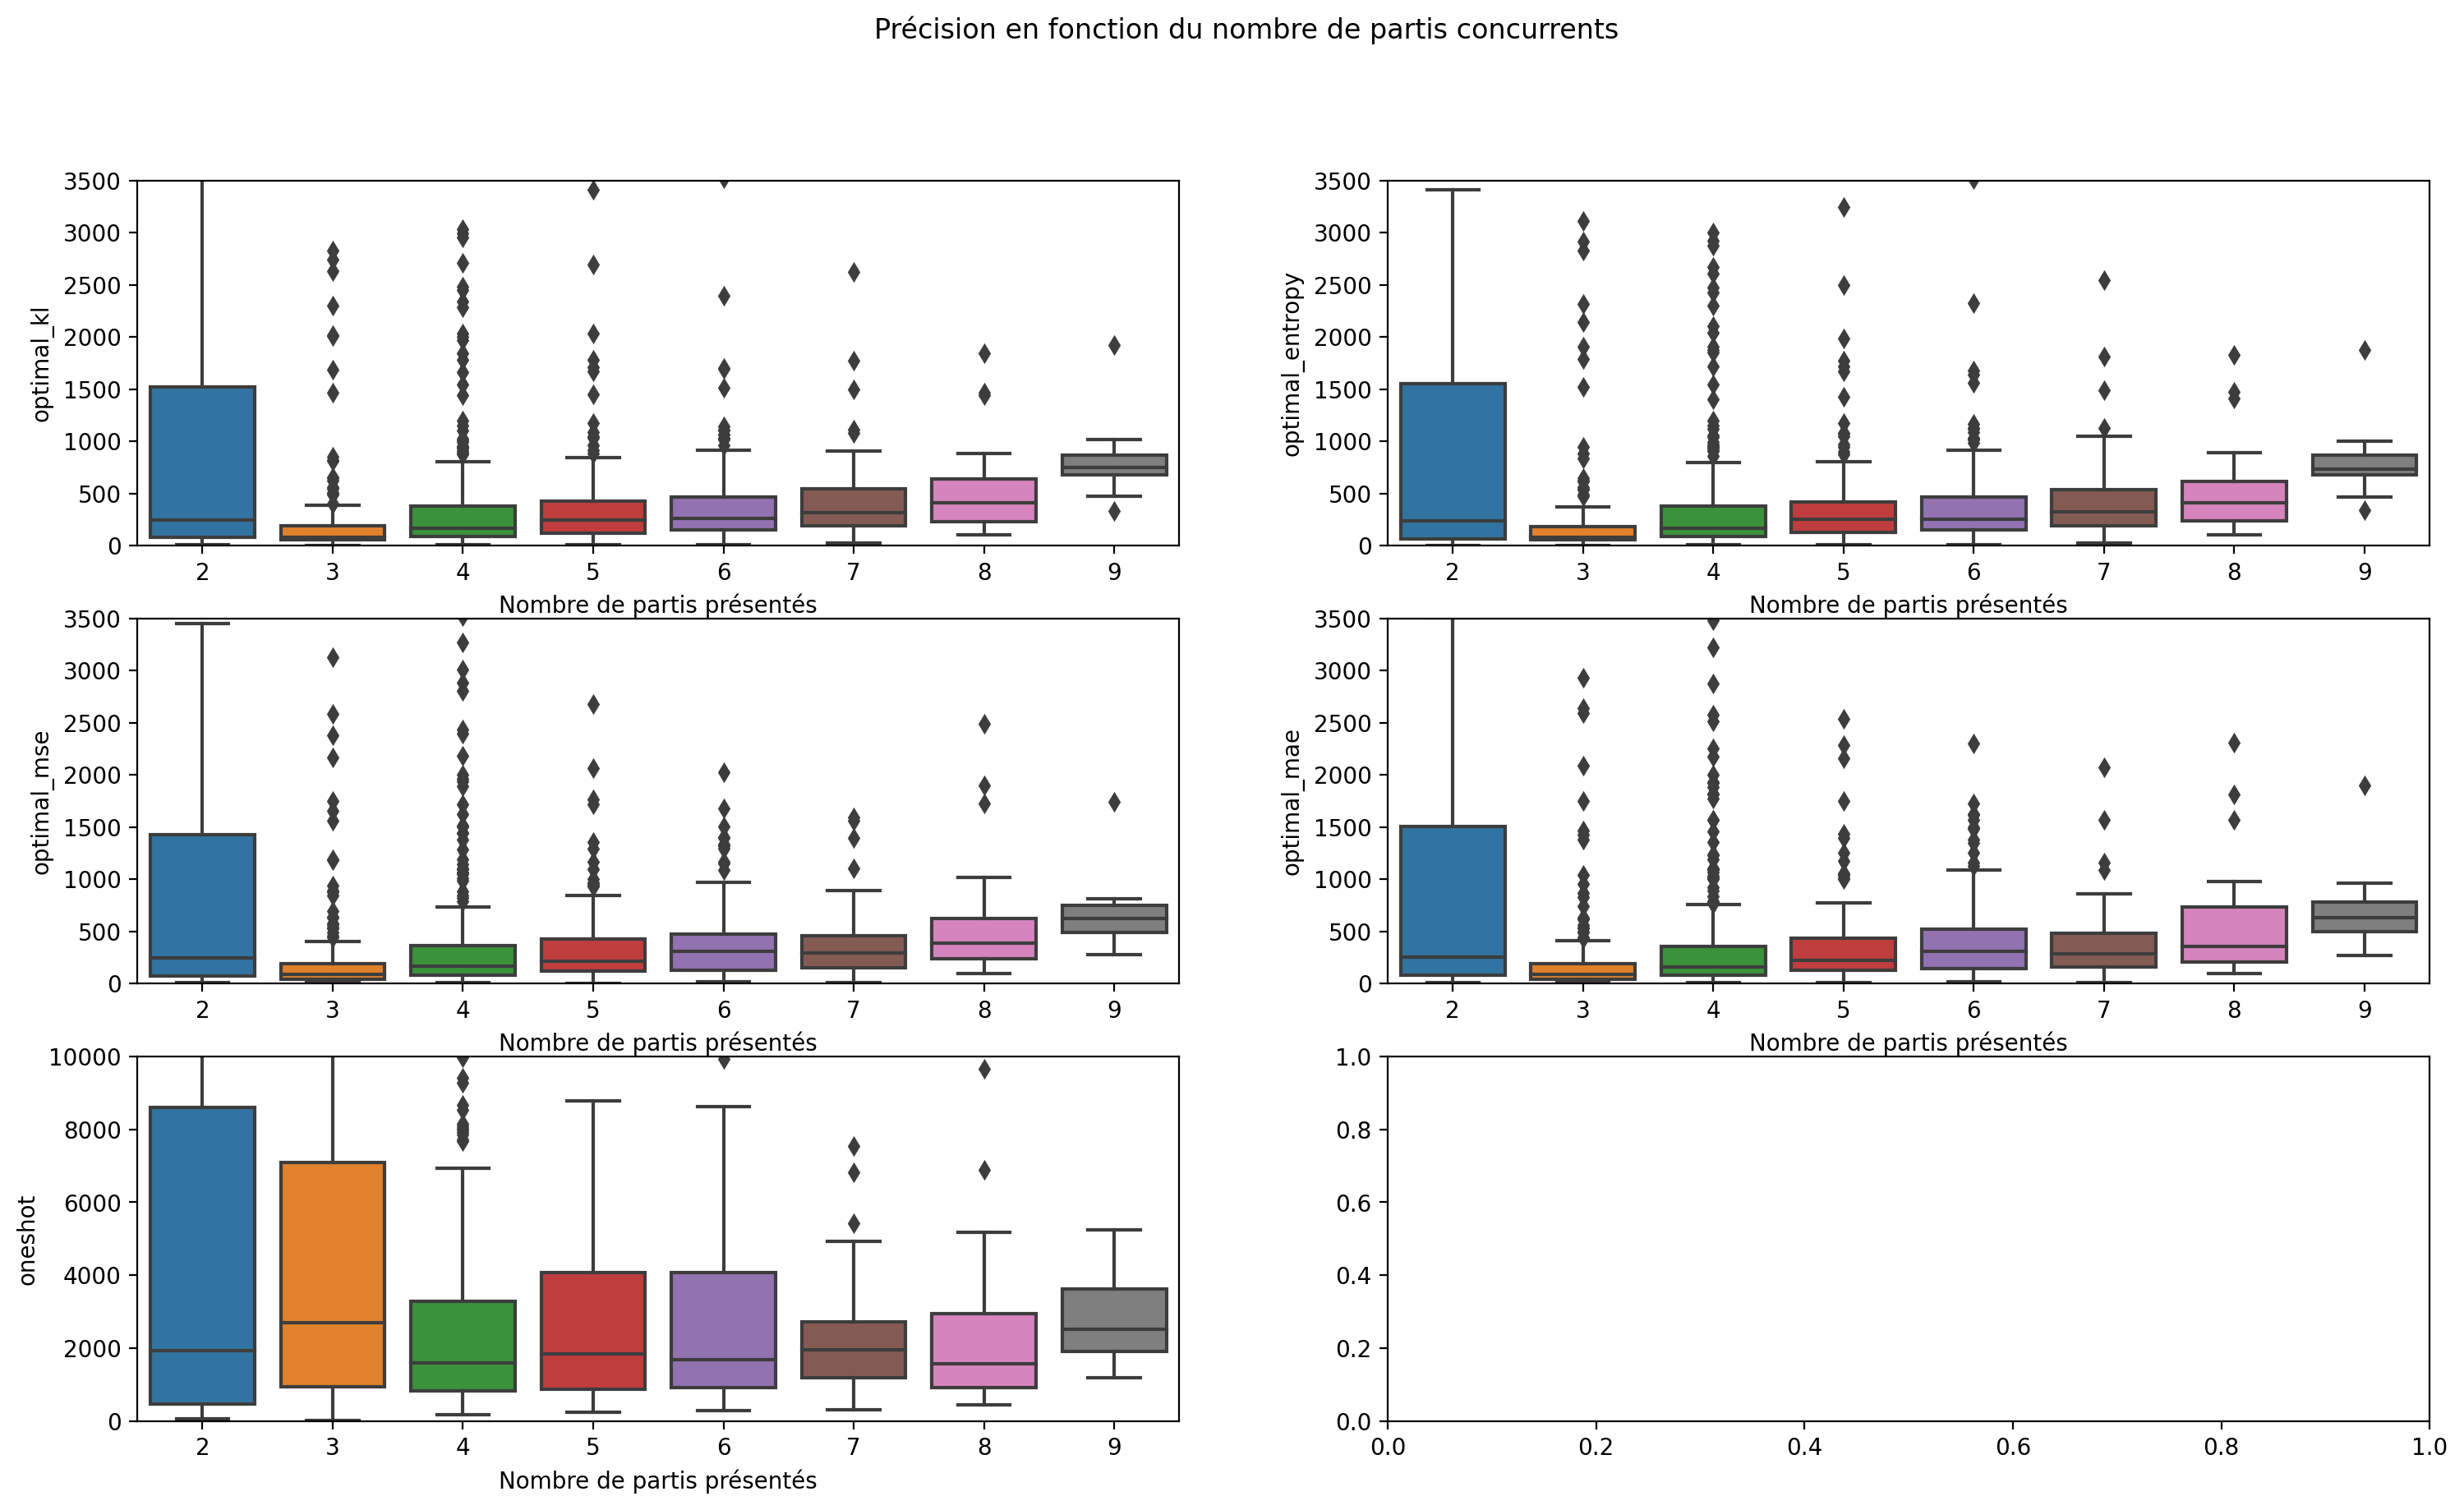

In [98]:
fig, axes = plt.subplots(nb_lignes,nb_colonnes,figsize=(18,10),dpi=200)
line=list(range(5000))
for i in range(nb_lignes):
  for j in range(nb_colonnes):
    if liste_mesures[i][j]!= '':
      ax=axes[i,j]
  # bss14["bins"]=pd.qcut(bss14["nb_candidates"])
      sns.boxplot(x="nb_candidates",
                    y=liste_mesures[i][j],
                    data=bss14,
                    ax=ax,
                    #  inner="quartile"
                  )
      ax.set_ylim(0, 3500)
      if liste_mesures[i][j]== 'oneshot':
        ax.set_ylim(0, 10000)
      ax.set_xlabel("Nombre de partis présentés")
fig.suptitle("Précision en fonction du nombre de partis concurrents")
fig.show()

4     6974
5     6126
6     3121
3     2644
2     2232
7     1582
8      489
9      273
12       1
Name: nb_candidates, dtype: int64

## Comparaison avec un tirage aléatoire unique

In [60]:


def optimal_size_one_shot(df:pd.DataFrame,n_samples:int=1000,measure=kl_div)->int:
  sample_size=int(df["sample"].iloc[0])
  lb=1
  ub=sample_size
  y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  y=random_sample_measure(df,poll_size=ub,n_samples=1,measure=measure)
  while y-y_hat<-1e-5 and ub<16*sample_size:
    lb=ub
    ub=ub*2
    y_hat=random_sample_measure(df,poll_size=ub,n_samples=n_samples,measure=measure)
  if y-y_hat>0:
    while ub!=lb and ub!=lb+1:
      n=int((ub+lb)/2)
      y_hat=random_sample_measure(df,poll_size=n,n_samples=n_samples,measure=measure)
      r=y-y_hat
      if r>=0:
        ub=n
      else:
        lb=n
  return ub

In [61]:
samples_sizes=[]
for i in tqdm(df.idpoll.unique()):
  poll_df=df[df.idpoll==i]
  year=poll_df.yr.iloc[0]
  country=poll_df.country.iloc[0]
  election=poll_df.election.iloc[0]
  system=poll_df.system.iloc[0]
  daysbeforeED=poll_df.daysbeforeED.iloc[0]
  nb_candidates=len(poll_df)
  if poll_df.vote_.sum()<100:
    nb_candidates+=1
  n=int(poll_df["sample"].iloc[0])

  oneshot=optimal_size_one_shot(poll_df)

  samples_sizes.append((i,n,oneshot,
                        year,country,election,system,
                        daysbeforeED,nb_candidates))


  0%|          | 0/23442 [00:00<?, ?it/s]

In [65]:
temp=pd.DataFrame(samples_sizes,
                    columns=['id','poll_sample','oneshot',
                            'year','country','election',
                            'system','daysbeforeED','nb_candidates'])

In [68]:
best_sample_size

,id,poll_sample,optimal_kl,optimal_entropy,optimal_mse,optimal_mae,year,country,election,system,daysbeforeED,nb_candidates,bins,oneshot
0,0,2124,23,26,19,22,1943.0,Australia,Legislative,Parliamentary,21.0,3,"(-0.001, 24.0]",2124
1,1,1940,45,45,114,135,1946.0,Australia,Legislative,Parliamentary,21.0,3,"(-0.001, 24.0]",1128
2,2,2011,22,22,94,86,1946.0,Australia,Legislative,Parliamentary,7.0,3,"(-0.001, 24.0]",32176
3,3,1884,29,28,85,79,1949.0,Australia,Legislative,Parliamentary,28.0,3,"(24.0, 59.0]",411
4,4,1869,29,29,132,138,1949.0,Australia,Legislative,Parliamentary,7.0,3,"(-0.001, 24.0]",678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23437,23752,3486,1440,1405,1096,1188,2016.0,Australia,Legislative,Parliamentary,8.0,4,"(-0.001, 24.0]",1941
23438,23753,1377,278,259,320,269,2016.0,Australia,Legislative,Parliamentary,5.0,4,"(-0.001, 24.0]",1033
23439,23754,2980,710,705,1102,1061,2016.0,Australia,Legislative,Parliamentary,4.0,4,"(-0.001, 24.0]",2468
23440,23755,4135,32203,33080,33080,42545,2016.0,Australia,Legislative,Parliamentary,3.0,4,"(-0.001, 24.0]",4135
